[Table of Contents](./table_of_contents.ipynb)

# Designing Kalman Filters

In [1]:
%matplotlib inline
from __future__ import division, print_function

In [2]:
#format the book
import book_format
book_format.set_style()

## Introduction

In the last chapter we worked with 'textbook' problems. These are problems that are easy to state, program in a few lines of code, and teach. Real world problems are rarely this simple. In this chapter we will work with more realistic examples, and learn how to evaluate filter performance.

We will begin by tracking a robot in a 2D space, such as a field or warehouse. We will start with a simple noisy sensor that outputs noisy $(x,y)$ coordinates which we will need to filter to generate a 2D track. Once we have mastered this concept, we will extend the problem significantly with more sensors and then adding control inputs. 

We will then move to a nonlinear problem. The world is nonlinear, but the Kalman filter is linear. Sometimes you can get away with using it for mildly nonlinear problems, sometimes you can't. I'll show you examples of both. This will set the stage for the remainder of the book, where we learn techniques for nonlinear problems. 

## Tracking a Robot

This first attempt at tracking a robot will closely resemble the 1D dog tracking problem of previous chapters. Instead of a sensor that outputs position in a hallway, we now have a sensor that supplies a noisy measurement of position in a 2D space. At each time $t$ it will provide an $(x,y)$ coordinate pair of the noisy measurement of the sensor's position in the field.

Implementation of code to interact with real sensors is beyond the scope of this book, so as before we will program simple simulations of the sensors. We will develop several of these sensors as we go, each with more complications, so as I program them I will just append a number to the function name. 

So let's start with a very simple sensor, one that simulates tracking an object traveling in a straight line. It is initialized with the initial position, velocity, and noise standard deviation. Each call to `read()` updates the position by one time step and returns the new measurement.

In [3]:
from numpy.random import randn

class PosSensor(object):
    def __init__(self, pos=(0, 0), vel=(0, 0), noise_std=1.):
        self.vel = vel
        self.noise_std = noise_std
        self.pos = [pos[0], pos[1]]
        
    def read(self):
        self.pos[0] += self.vel[0]
        self.pos[1] += self.vel[1]
        
        return [self.pos[0] + randn() * self.noise_std,
                self.pos[1] + randn() * self.noise_std]

A quick test to verify that it works as we expect.

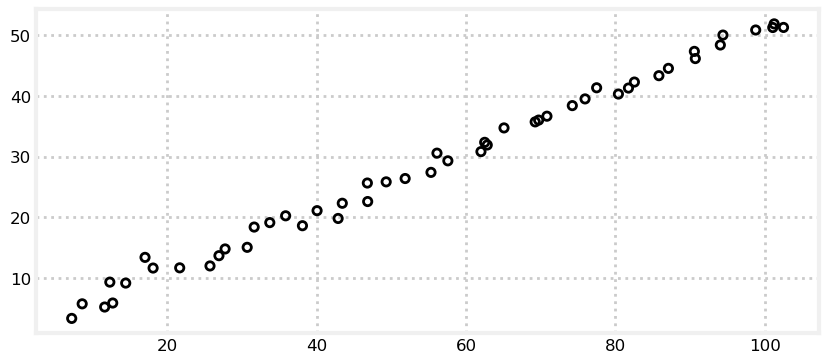

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from kf_book.book_plots import plot_measurements

pos, vel = (4, 3), (2, 1)
sensor = PosSensor(pos, vel, noise_std=1)
ps = np.array([sensor.read() for _ in range(50)])
plot_measurements(ps[:, 0], ps[:, 1]);

That looks correct. The slope is 1/2, as we would expect with a velocity of (2, 1), and the data seems to start at near (6, 4). It doesn't look realistic. This is still a 'textbook' representation. As we continue we will add complications that adds real world behavior. 

### Choose the State Variables

As always, the first step is to choose our state variables. We are tracking in two dimensions and have a sensor that gives us a reading in each of those two dimensions, so we  know that we have the two *observed variables* $x$ and $y$. If we created our Kalman filter using only those two variables the performance would not be very good because we would be ignoring the information velocity can provide to us. We will want to incorporate velocity into our equations as well. I will represent this as

$$\mathbf x = 
\begin{bmatrix}x & \dot x & y & \dot y\end{bmatrix}^\mathsf T$$

There is nothing special about this organization. I could have used $\begin{bmatrix}x & y & \dot x &  \dot y\end{bmatrix}^\mathsf T$ or something less logical. I just need to be consistent in the rest of the matrices. I like keeping positions and velocities next to each other because it keeps the covariances between positions and velocities in the same sub block of the covariance matrix. In my formulation `P[1,0]` contains the covariance of of $x$ and $\dot x$. In the alternative formulation that covariance is at `P[2, 0]`. This gets worse as the number of dimension increases.

Let's pause and address how you identify the hidden variables. This example is somewhat obvious because we've already worked through the 1D case, but other problems won't be obvious There is no easy answer to this question. The first thing to ask yourself is what is the interpretation of the first and second derivatives of the data from the sensors. We do that because obtaining the first and second derivatives is mathematically trivial if you are reading from the sensors using a fixed time step. The first derivative is just the difference between two successive readings. In our tracking case the first derivative has an obvious physical interpretation: the difference between two successive positions is velocity. 

Beyond this you can start looking at how you might combine the data from two or more different sensors to produce more information. This opens up the field of *sensor fusion*, and we will be covering examples of this in later sections. For now, recognize that choosing the appropriate state variables is paramount to getting the best possible performance from your filter. Once you have chosen hidden variables, you must run many tests to ensure that you are generating real results for them. The Kalman filter runs whatever model you give it; if your model cannot generate good information for the hidden variables the Kalman filter output will be nonsensical.

### Design State Transition Function

Our next step is to design the state transition function. Recall that the state transition function is implemented as a matrix $\mathbf F$ that we multiply with the previous state of our system to get the next state, like so. 

$$\mathbf{\bar x} = \mathbf{Fx}$$

I will not belabor this as it is very similar to the 1-D case we did in the previous chapter. The state transition equations are

$$
\begin{aligned}
x &= 1x + \Delta t \dot x + 0y + 0 \dot y \\
v_x &= 0x + 1\dot x + 0y + 0 \dot y \\
y &= 0x + 0\dot x + 1y + \Delta t \dot y \\
v_y &= 0x + 0\dot x + 0y + 1 \dot y
\end{aligned}
$$

Laying it out that way shows us both the values and row-column organization required for $\small\mathbf F$. We convert this to matrix-vector form:

$$
\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix} = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix}\begin{bmatrix}x \\ \dot x \\ y \\ \dot y\end{bmatrix}$$

So, let's do this in Python. It is very simple; the only thing new here is setting `dim_z` to 2. We will see why it is set to 2 in step 4.

In [5]:
from filterpy.kalman import KalmanFilter

tracker = KalmanFilter(dim_x=4, dim_z=2)
dt = 1.   # time step 1 second

tracker.F = np.array([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])

### Design the Process Noise Matrix

FilterPy can compute the $\mathbf Q$ matrix for us. For simplicity I will assume the noise is a discrete time Wiener process - that it is constant for each time period. This assumption allows me to use a variance to specify how much I think the model changes between steps. Revisit the Kalman Filter Math chapter if this is not clear.

In [6]:
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

q = Q_discrete_white_noise(dim=2, dt=dt, var=0.001)
tracker.Q = block_diag(q, q)
print(tracker.Q)

[[0.    0.001 0.    0.   ]
 [0.001 0.001 0.    0.   ]
 [0.    0.    0.    0.001]
 [0.    0.    0.001 0.001]]


Here I assume the noise in x and y are independent, so the covariances between any x and y variable should be zero. This allows me to compute $\mathbf Q$ for one dimension, and then use `block_diag` to copy it for the x and y axis.

### Design the Control Function

We haven't yet added controls to our robot, so there is nothing to be done for this step. The `KalmanFilter` class initializes `B` to zero under the assumption that there is no control input,
so there is no code to write. If you like, you can be explicit and set `tracker.B` to 0, but as you can see it already has that value.

In [7]:
tracker.B

### Design the Measurement Function

The measurement function $\mathbf H$ defines how we go from the state variables to the measurements using the equation $\mathbf z = \mathbf{Hx}$. In this case we have measurements for (x,y), so we will design $\mathbf z$ as $\begin{bmatrix}x & y\end{bmatrix}^\mathsf T$ which is dimension 2x1. Our state variable is size 4x1. We can deduce the required size for $\textbf{H}$ by recalling that multiplying a matrix of size MxN by NxP yields a matrix of size MxP. Thus,

$$(2\times 1) = (a\times b)(4 \times 1) = (2\times 4)(4\times 1)$$

So, $\textbf{H}$ is 2x4.

Filling in the values for $\textbf{H}$ is easy because the measurement is the position of the robot, which is the $x$ and $y$ variables of the state $\textbf{x}$. Let's make this slightly more interesting by deciding we want to change units. The measurements are returned in feet, and that we desire to work in meters. $\textbf{H}$ changes from state to measurement, so the conversion is $\mathsf{feet} = \mathsf{meters} / 0.3048$. This yields

$$\mathbf H =
\begin{bmatrix} 
\frac{1}{0.3048} & 0 & 0 & 0 \\
0 & 0 & \frac{1}{0.3048} & 0
\end{bmatrix}
$$

which corresponds to these linear equations

$$
\begin{aligned}
z_x &= (\frac{x}{0.3048}) + (0* v_x) + (0*y) + (0 * v_y) = \frac{x}{0.3048}\\
z_y &= (0*x) + (0* v_x) + (\frac{y}{0.3048}) + (0 * v_y) = \frac{y}{0.3048}
\end{aligned}
$$

This is a simple problem, and we could have found the equations directly without going through the dimensional analysis that I did above. But it is useful to remember that the equations of the Kalman filter imply a specific dimensionality for all of the matrices, and when I start to get lost as to how to design something it is useful to look at the matrix dimensions.

Here is my implementation:

In [8]:
tracker.H = np.array([[1/0.3048, 0, 0,        0],
                      [0,        0, 1/0.3048, 0]])

### Design the Measurement Noise Matrix

We assume that the $x$ and $y$ variables are independent white Gaussian processes. That is, the noise in x is not in any way dependent on the noise in y, and the noise is normally distributed about the mean 0. For now let's set the variance for $x$ and $y$ to be 5 meters$^2$. They are independent, so there is no covariance, and our off diagonals will be 0. This gives us:

$$\mathbf R = \begin{bmatrix}\sigma_x^2 & \sigma_y\sigma_x \\ \sigma_x\sigma_y & \sigma_{y}^2\end{bmatrix} 
= \begin{bmatrix}5&0\\0&5\end{bmatrix}$$

It is a $2{\times}2$ matrix because we have 2 sensor inputs, and covariance matrices are always of size $n{\times}n$ for $n$ variables. In Python we write:

In [9]:
tracker.R = np.array([[5., 0],
                      [0, 5]])
tracker.R

array([[5., 0.],
       [0., 5.]])

### Initial Conditions

For our simple problem we will set the initial position at (0,0) with a velocity of (0,0). Since that is a pure guess, we will set the covariance matrix $\small\mathbf P$ to a large value.

$$ \mathbf x = \begin{bmatrix}0\\0\\0\\0\end{bmatrix}, \,
\mathbf P = \begin{bmatrix}500&0&0&0\\0&500&0&0\\0&0&500&0\\0&0&0&500\end{bmatrix}$$

The Python implementation is

In [10]:
tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

### Implement the Filter

Design is complete, now we just have to write the code to run the filter and output the data in the format of our choice. We will run the code for 30 iterations.

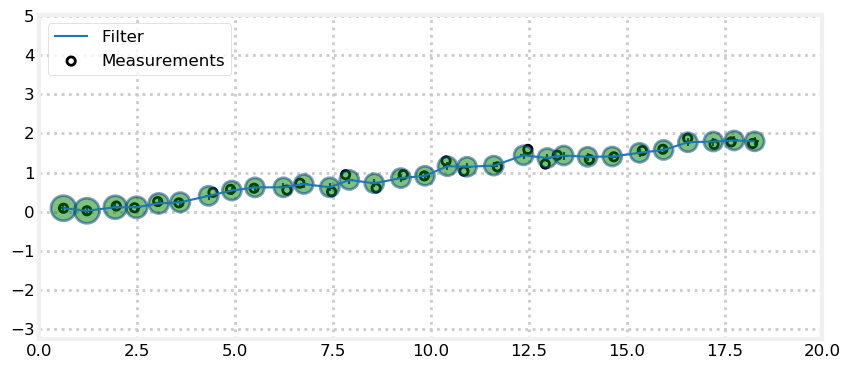

In [11]:
from filterpy.stats import plot_covariance_ellipse
from kf_book.book_plots import plot_filter

R_std = 0.35
Q_std = 0.04

def tracker1():
    tracker = KalmanFilter(dim_x=4, dim_z=2)
    dt = 1.0   # time step

    tracker.F = np.array([[1, dt, 0,  0],
                          [0,  1, 0,  0],
                          [0,  0, 1, dt],
                          [0,  0, 0,  1]])
    tracker.u = 0.
    tracker.H = np.array([[1/0.3048, 0, 0, 0],
                          [0, 0, 1/0.3048, 0]])

    tracker.R = np.eye(2) * R_std**2
    q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
    tracker.Q = block_diag(q, q)
    tracker.x = np.array([[0, 0, 0, 0]]).T
    tracker.P = np.eye(4) * 500.
    return tracker

# simulate robot movement
N = 30
sensor = PosSensor((0, 0), (2, .2), noise_std=R_std)

zs = np.array([sensor.read() for _ in range(N)])

# run filter
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)
    
#plot results
zs *= .3048 # convert to meters
plot_filter(mu[:, 0], mu[:, 2])
plot_measurements(zs[:, 0], zs[:, 1])
plt.legend(loc=2)
plt.xlim(0, 20);

I encourage you to play with this, setting $\mathbf Q$ and $\mathbf R$ to various values.  However, we did a fair amount of that sort of thing in the last chapters, and we have a lot of material to cover, so I will move on to more complicated cases where we will also have a chance to experience changing these values.

I plotted the $3\sigma$ the covariance ellipse for $x$ and $y$ in green. Can you explain their shape? Perhaps you were expecting a tilted ellipse, as in the last chapters. If so, recall that in those chapters we were not plotting $x$ against $y$, but $x$ against $\dot x$. $x$ is correlated to $\dot x$, but $x$ is not correlated or dependent on $y$. Therefore our ellipses are not tilted. Furthermore, the noise for both $x$ and $y$ are modeled to have the same noise standard deviation. If we were to set R to, for example,

$$\mathbf R = \begin{bmatrix}1&0\\0&.5\end{bmatrix}$$

we would be telling the Kalman filter that there is more noise in $x$ than $y$, and our ellipses would be longer than they are tall.

The final value for $\mathbf P$ tells us everything we need to know about the correlation between the state variables. If we look at the diagonal alone we see the variance for each variable. In other words $\mathbf P_{0,0}$ is the variance for x, $\mathbf P_{1,1}$ is the variance for $\dot x$, $\mathbf P_{2,2}$ is the variance for y, and $\mathbf P_{3,3}$ is the variance for $\dot y$. We can extract the diagonal of a matrix using `numpy.diag()`.

In [12]:
print(np.diag(robot_tracker.P))

[0.007 0.003 0.007 0.003]


The covariance matrix contains four $2{\times}2$ matrices that you should be able to easily pick out. This is due to the correlation of $x$ to $\dot x$, and of $y$ to $\dot y$. The upper left hand side shows the covariance of $x$ to $\dot x$.

[[0.007 0.003]
 [0.003 0.003]]


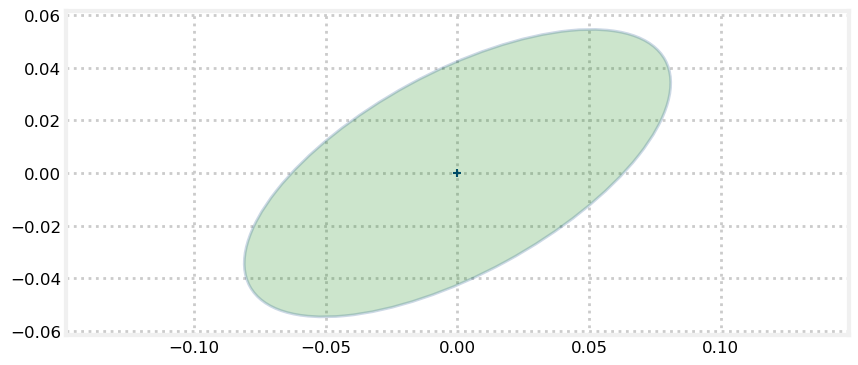

In [13]:
c = robot_tracker.P[0:2, 0:2]
print(c)
plot_covariance_ellipse((0, 0), cov=c, fc='g', alpha=0.2)

The covariance contains the data for $x$ and $\dot x$ in the upper left because of how it is organized. Recall that entries $\mathbf P_{i,j}$ and $\mathbf P_{j,i}$ contain $\sigma_i\sigma_j$.

Finally, let's look at the lower left side of $\mathbf P$, which is all 0s. Why 0s? Consider $\mathbf P_{3,0}$. That stores the term $\sigma_3\sigma_0$, which is the covariance between $\dot y$ and $x$. These are independent, so the term will be 0. The rest of the terms are for similarly independent variables.

In [14]:
robot_tracker.P[2:4, 0:2]

array([[0., 0.],
       [0., 0.]])

## Filter Order

We have only studied tracking position and velocity. It has worked well, but only because I have been selecting problems for which this is an appropriate choice. You now have enough experience with the Kalman filter to consider this in more general terms.

What do I mean by order? In the context of these system models it is the number of derivatives required to accurately model a system. Consider a system that does not change, such as the height of a building. There is no change, so there is no need for a derivative, and the order of the system is zero. We could express this in an equation as $x = 312.5$.

A first order system has a first derivative. For example, change of position is velocity, and we can write this as

$$ v = \frac{dx}{dt}$$

which we integrate into the Newtonian equation

$$ x = vt + x_0.$$

This is also called a *constant velocity* model, because of the assumption of a constant velocity.

A second order system has a second derivative. The second derivative of position is acceleration, with the equation

$$a = \frac{d^2x}{dt^2}$$

which we integrate into 

$$ x = \frac{1}{2}at^2 +v_0t + x_0.$$

This is also known as a *constant acceleration* model.

Another, equivalent way of looking at this is to consider the order of the polynomial. The constant acceleration model has a second derivative, so it is second order. Likewise, the polynomial $x = \frac{1}{2}at^2 +v_0t + x_0$ is second order.

When we design the state variables and process model we must choose the order of the system we want to model. Let's say we are tracking something with a constant velocity. No real world process is perfect, and so there will be slight variations in the velocity over short time period. You might reason that the best approach is to use a second order filter, allowing the acceleration term to deal with the slight variations in velocity. 

In practice that doesn't work well. To thoroughly understand this issue let's see the effects of using a  process model that does not match the order of the system being filtered. 

First we need a system to filter. I'll write a class to simulate an object with constant velocity. Essentially no physical system has a truly constant velocity, so on each update we alter the velocity by a small amount. I also write a sensor to simulate Gaussian noise in a sensor. The code is below, and I plot an example run to verify that it is working correctly. 

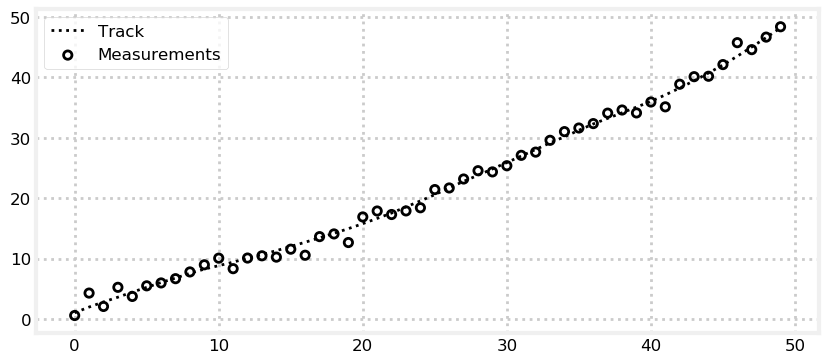

In [15]:
from kf_book.book_plots import plot_track

class ConstantVelocityObject(object):
    def __init__(self, x0=0, vel=1., noise_scale=0.06):
        self.x = x0
        self.vel = vel
        self.noise_scale = noise_scale

    def update(self):
        self.vel += randn() * self.noise_scale
        self.x += self.vel
        return (self.x, self.vel)

def sense(x, noise_scale=1.):
    return x[0] + randn()*noise_scale

np.random.seed(124)
obj = ConstantVelocityObject()

xs, zs = [], []
for i in range(50):
    x = obj.update()
    z = sense(x)
    xs.append(x)
    zs.append(z)

xs = np.asarray(xs)

plot_track(xs[:, 0])
plot_measurements(range(len(zs)), zs)
plt.legend(loc='best');

I am satisfied with this plot. The track is not perfectly straight due to the noise that we added to the system - this could be the track of a person walking down the street, or perhaps of an aircraft being buffeted by variable winds. There is no intentional acceleration here, so we call it a constant velocity system. Again, you may be asking yourself that since there is in fact a tiny bit of acceleration going on why would we not use a second order Kalman filter to account for those changes? Let's find out.

How does one design a zero order, first order, or second order Kalman filter? We have been doing it all along, but just not using those terms. It might be slightly tedious, but I will elaborate fully on each - if the concept is clear to you feel free to skim a bit.

### Zero Order Kalman Filter

A zero order Kalman filter is just a filter that tracks with no derivatives. We are tracking position, so that means we only have a state variable for position (no velocity or acceleration), and the state transition function also only accounts for position. Using the matrix formulation we would say that the state variable is

$$\mathbf x = \begin{bmatrix}x\end{bmatrix}$$

The state transition function is very simple. There is no change in position, so we need to model $x=x$; in other words, *x* at time t+1 is the same as it was at time t. In matrix form, our state transition function is

$$\mathbf F = \begin{bmatrix}1\end{bmatrix}$$

The measurement function is very easy. Recall that we need to define how to convert the state variable $\mathbf x$ into a measurement. We will assume that our measurements are positions. The state variable only contains a position, so we get

$$\mathbf H = \begin{bmatrix}1\end{bmatrix}$$

Let's write a function that constructs and returns a zero order Kalman filter.

In [16]:
def ZeroOrderKF(R, Q, P=20):
    """ Create zero order Kalman filter.
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=1, dim_z=1)
    kf.x = np.array([0.])
    kf.R *= R
    kf.Q *= Q
    kf.P *= P
    kf.F = np.eye(1)
    kf.H = np.eye(1)
    return kf

### First Order Kalman Filter

A first order Kalman filter tracks a first order system, such as position and velocity. We already did this for the dog tracking problem above, so this should be very clear. But let's do it again.

A first order system has position and velocity, so the state variable needs both of these. The matrix formulation could be

$$ \mathbf x = \begin{bmatrix}x\\\dot x\end{bmatrix}$$

So now we have to design our state transition. The Newtonian equations for a time step are:

$$\begin{aligned} x_t &= x_{t-1} + v\Delta t \\
 v_t &= v_{t-1}\end{aligned}$$
 
Recall that we need to convert this into the linear equation

$$\begin{bmatrix}x\\\dot x\end{bmatrix} = \mathbf F\begin{bmatrix}x\\\dot x\end{bmatrix}$$

Setting

$$\mathbf F = \begin{bmatrix}1 &\Delta t\\ 0 & 1\end{bmatrix}$$

gives us the equations above.

Finally, we design the measurement function. The measurement function needs to implement

$$\mathbf z = \mathbf{Hx}$$

Our sensor still only reads position, so it should take the position from the state, and 0 out the velocity and acceleration, like so:

$$\mathbf H = \begin{bmatrix}1 & 0 \end{bmatrix}$$

This function constructs and returns a first order Kalman filter.

In [17]:
def FirstOrderKF(R, Q, dt):
    """ Create first order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf

### Second Order Kalman Filter

A second order Kalman filter tracks a second order system, such as position, velocity and acceleration. The state variable will be

$$ \mathbf x = \begin{bmatrix}x\\\dot x\\\ddot{x}\end{bmatrix}$$

So now we have to design our state transition. The Newtonian equations for a time step are:

$$\begin{aligned} x_t &= x_{t-1} + v_{t-1}\Delta t + 0.5a_{t-1} \Delta t^2 \\
 v_t &= v_{t-1} + a_{t-1}\Delta t \\
 a_t &= a_{t-1}\end{aligned}$$
 
Recall that we need to convert this into the linear equation

$$\begin{bmatrix}x\\\dot x\\\ddot{x}\end{bmatrix} = \mathbf F\begin{bmatrix}x\\\dot x\\\ddot{x}\end{bmatrix}$$

Setting

$$\mathbf F = \begin{bmatrix}1 & \Delta t &.5\Delta t^2\\ 
0 & 1 & \Delta t \\
0 & 0 & 1\end{bmatrix}$$

gives us the equations above. 

Finally, we design the measurement function. The measurement function needs to implement

$$z = \mathbf{Hx}$$

Our sensor still only reads position, so it should take the position from the state, and 0 out the velocity, like so:

$$\mathbf H = \begin{bmatrix}1 & 0 & 0\end{bmatrix}$$

This function constructs and returns a second order Kalman filter.

In [18]:
def SecondOrderKF(R_std, Q, dt, P=100):
    """ Create second order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=3, dim_z=1)
    kf.x = np.zeros(3)
    kf.P[0, 0] = P
    kf.P[1, 1] = 1
    kf.P[2, 2] = 1
    kf.R *= R_std**2
    kf.Q = Q_discrete_white_noise(3, dt, Q)
    kf.F = np.array([[1., dt, .5*dt*dt],
                     [0., 1.,       dt],
                     [0., 0.,       1.]])
    kf.H = np.array([[1., 0., 0.]])
    return kf

## Evaluating Filter Order

Now we can run each Kalman filter against the simulation and evaluate the results. 

How do we evaluate the results? We can do this qualitatively by plotting the track and the Kalman filter output and eyeballing the results. However, a rigorous approach uses mathematics. Recall that the system covariance matrix $\mathbf P$ contains the computed variance and covariances for each of the state variables. The diagonal contains the variance. Remember that roughly 99% of all measurements fall within $3\sigma$ if the noise is Gaussian. If this is not clear please review the Gaussian chapter before continuing, as this is an important point. 

So we can evaluate the filter by looking at the residuals between the estimated state and actual state and comparing them to the standard deviations which we derive from $\mathbf P$. If the filter is performing correctly 99% of the residuals will fall within $3\sigma$. This is true for all the state variables, not just for the position. 

I must mention that this is only true for simulated systems. Real sensors are not perfectly Gaussian, and you may need to expand your criteria to, say, $5\sigma$ with real sensor data.

So let's run the first order Kalman filter against our first order system and access its performance. You can probably guess that it will do well, but let's look at it using the standard deviations.

First, let's write a routine to generate the noisy measurements for us.

In [19]:
def simulate_system(Q, count):
    obj = ConstantVelocityObject(x0=.0, vel=0.5, noise_scale=Q)
    xs, zs = [], []
    for i in range(count):
        x = obj.update()
        z = sense(x)
        xs.append(x)
        zs.append(z)
    return np.array(xs), np.array(zs)

And now a routine to perform the filtering and save the output in a `Saver` object.

In [20]:
from filterpy.common import Saver

def filter_data(kf, zs):
    s = Saver(kf)
    kf.batch_filter(zs, saver=s)
    s.to_array()
    return s

Now we are prepared to run the filter and look at the results.

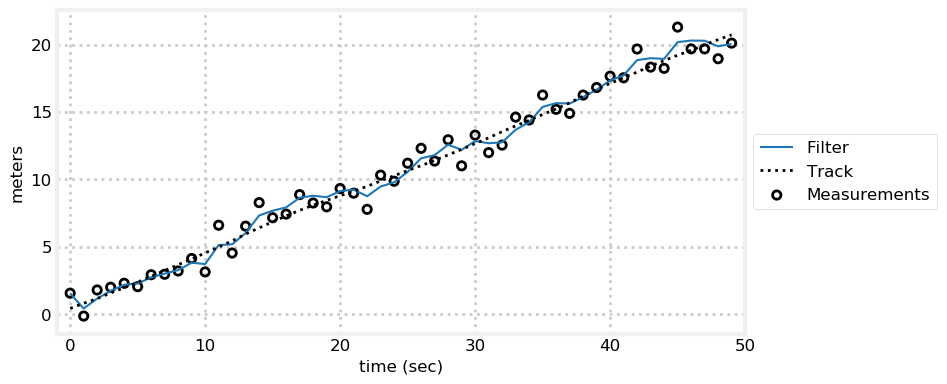

In [21]:
from kf_book.book_plots import plot_kf_output

R, Q = 1, 0.03
xs, zs = simulate_system(Q=Q, count=50)

kf = FirstOrderKF(R, Q, dt=1)
data1 = filter_data(kf, zs)

plot_kf_output(xs, data1.x, data1.z)

It looks like the filter is performing well, but it is hard to tell exactly how well. Let's look at the residuals and see if they help. We'll do this a lot, so I'll write a function to plot them.

In [22]:
from kf_book.book_plots import plot_residual_limits, set_labels

def plot_residuals(xs, data, col, title, y_label, stds=1):
    res = xs - data.x[:, col]
    plt.plot(res)
    plot_residual_limits(data.P[:, col, col], stds)
    set_labels(title, 'time (sec)', y_label)

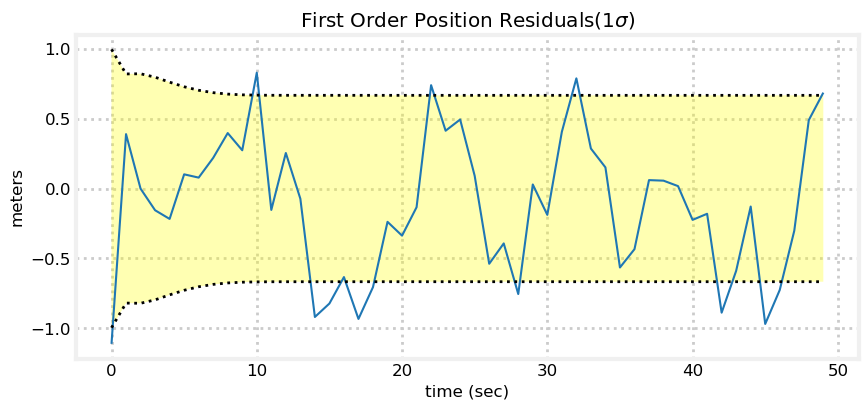

In [23]:
plot_residuals(xs[:, 0], data1, 0, 
               title='First Order Position Residuals(1$\sigma$)',
               y_label='meters')   

How do we interpret this plot? The residual is drawn as the jagged line - the difference between the measurement and the predicted position. If there was no measurement noise and the Kalman filter prediction was always perfect the residual would always be zero. So the ideal output would be a horizontal line at 0. We can see that the residual is centered around 0, so this gives us confidence that the noise is Gaussian (because the errors fall equally above and below 0). The yellow area between dotted lines show the theoretical performance of the filter for 1 standard deviations. In other words, approximately 68% of the errors should fall within the dotted lines. The residual falls within this range, so we see that the filter is performing well, and that it is not diverging.

Let's look at the residuals for velocity. 

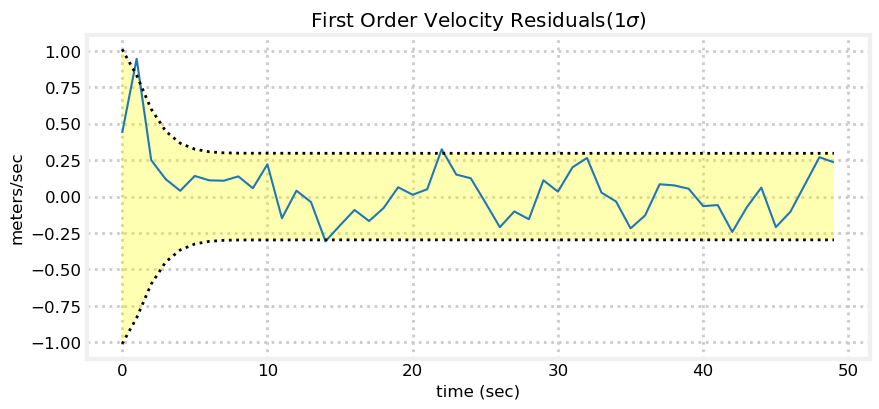

In [24]:
plot_residuals(xs[:, 1], data1, 1, 
               title='First Order Velocity Residuals(1$\sigma$)',
               y_label='meters/sec')   

Again, as expected, the residual falls within the theoretical performance of the filter, so we feel confident that the filter is well designed for this system. 

Now let's do the same thing using the zero order Kalman filter. All of the code and math is largely the same, so let's just look at the results without discussing the implementation much.

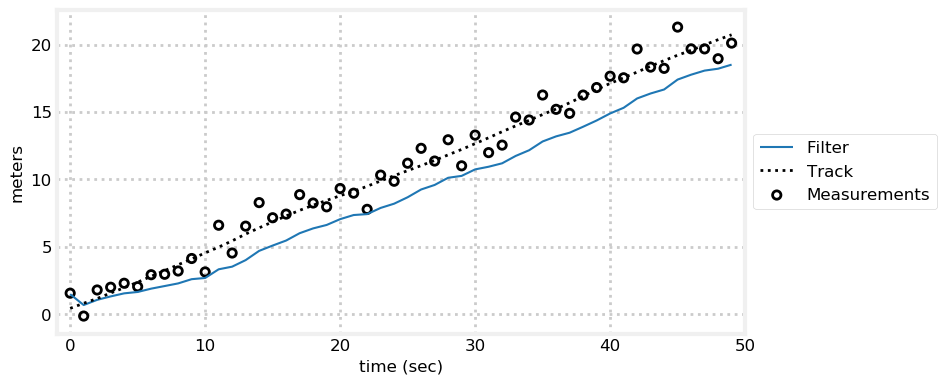

In [25]:
kf0 = ZeroOrderKF(R, Q)
data0 = filter_data(kf0, zs)
plot_kf_output(xs, data0.x, data0.z)

As we would expect, the filter has problems. Think back to the g-h filter, where we incorporated acceleration into the system. The g-h filter always lagged the input because there were not enough terms to allow the filter to adjust quickly enough to the changes in velocity. On every `predict()` step the Kalman filter assumes that there is no change in position - if the current position is 4.3 it will predict that the position at the next time period is 4.3. Of course, the actual position is closer to 5.3. The measurement, with noise, might be 5.4, so the filter chooses an estimate part way between 4.3 and 5.4, causing it to lag the actual value of 5.3 by a significant amount. This same thing happens in the next step, the next one, and so on. The filter never catches up.

This raises a very important point. The assumption of 'constant' is an assumption of constant-ness between discrete samples only. The filter's output can still change over time.

Now let's look at the residuals. We are not tracking velocity, so we can only look at the residual for position.

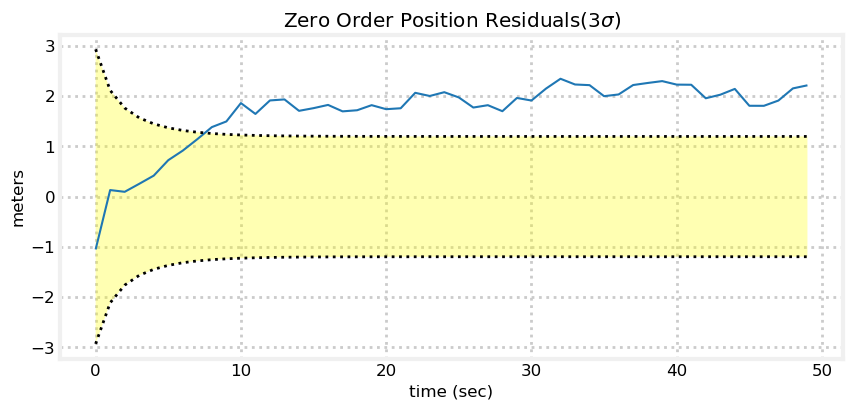

In [26]:
plot_residuals(xs[:, 0], data0, 0, 
               title='Zero Order Position Residuals(3$\sigma$)',
               y_label='meters',
               stds=3)

We can see that the filter diverges almost immediately. After a few seconds the residual exceeds the bounds of three standard deviations. It is important to understand that the covariance matrix $\mathbf P$ is only reporting the *theoretical* performance of the filter *assuming* all of the inputs are correct. In other words, this Kalman filter is diverging, but $\mathbf P$ implies that the Kalman filter's estimates are getting better and better with time because the variance is getting smaller. The filter has no way to know that you are lying to it about the system. This is sometimes referred to a *smug* filter - it is overconfident in its performance.

In this system the divergence is immediate and striking. In many systems it will only be gradual, and/or slight. It is important to look at charts like these for your systems to ensure that the performance of the filter is within the bounds of its theoretical performance.

Now let's try a second order system. This might strike you as a good thing to do. After all, we know there is a bit of noise in the movement of the simulated object, which implies there is some acceleration. Why not model the acceleration with a second order model? If there is no acceleration, the acceleration should just be estimated to be 0, right?. But is that what happens? Think about it before going on.

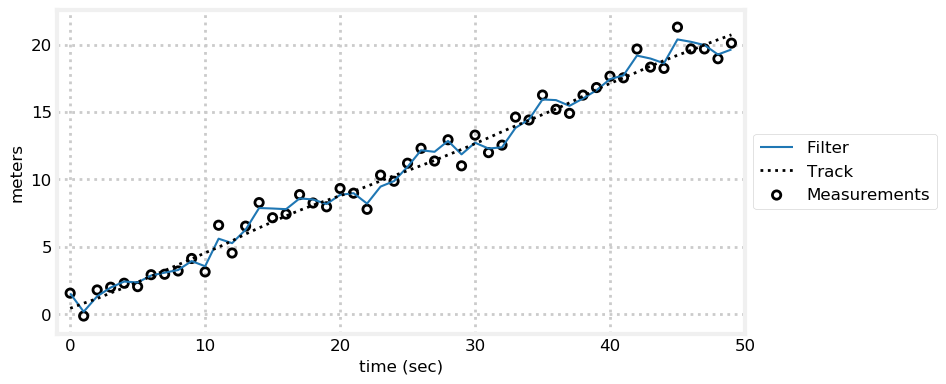

In [27]:
kf2 = SecondOrderKF(R, Q, dt=1)
data2 = filter_data(kf2, zs)
plot_kf_output(xs, data2.x, data2.z)

Did this perform as you expected?

We can see that second order filter performs poorly compared to the first order filter. Why? This  filter models acceleration, and so the large changes in the measurement gets interpreted as acceleration instead of noise. Thus the filter closely tracks the noise. Not only that, but it *overshoots* the noise in places if the noise is consistently above or below the track because the filter incorrectly assumes an acceleration that does not exist, and so it's prediction goes further and further away from the track on each measurement. This is not a good state of affairs.

Still, the track doesn't look *horrible*. Let's see the story that the residuals tell. I will add a wrinkle here. The residuals for the second order system do not look terrible in that they do not diverge or exceed three standard deviations. However, it is very telling to look at the residuals for the first order vs the second order filter, so I have plotted both on the same graph.

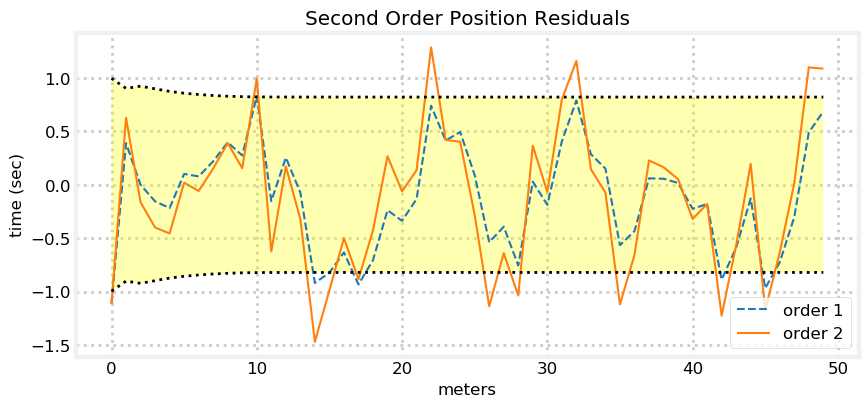

In [28]:
res2 = xs[:, 0] - data2.x[:, 0]
res1 = xs[:, 0] - data1.x[:, 0]

plt.plot(res1, ls="--", label='order 1')
plt.plot(res2, label='order 2')
plot_residual_limits(data2.P[:, 0, 0])
set_labels('Second Order Position Residuals',
           'meters', 'time (sec)')
plt.legend();

The second order position residuals are slightly worse than the residuals of the first order filter, but they still fall within the theoretical limits of the filter. There is nothing very alarming here.

Now let's look at the residuals for the velocity.

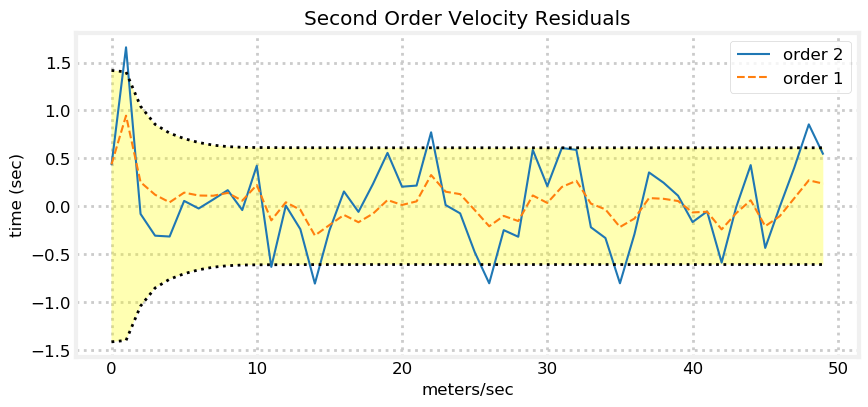

In [29]:
res2 = xs[:, 1] - data2.x[:, 1]
res1 = xs[:, 1] - data1.x[:, 1]

plt.plot(res2, label='order 2')
plt.plot(res1, ls='--', label='order 1')
plot_residual_limits(data2.P[:, 1, 1])
set_labels('Second Order Velocity Residuals', 
                      'meters/sec', 'time (sec)')
plt.legend();

Here the story is very different. While the residuals of the second order system fall within the theoretical bounds of the filter's performance, we can see that the residuals are *far* worse than for the first order filter. This is the usual result for this scenario. The filter is assuming that there is acceleration that does not exist. It mistakes noise in the measurement as acceleration and this gets added into the velocity estimate on every predict cycle. Of course the acceleration is not actually there and so the residual for the velocity is much larger than its optimum.

I have one more trick up my sleeve. We have a first order system; i.e. the velocity is more-or-less constant. Real world systems are never perfect, so of course the velocity is never exactly the same between time periods. When we use a first order filter we account for that slight variation in velocity with the *process noise*. The matrix $\mathbf Q$ is computed to account for this slight variation. If we move to a second order filter we are now accounting for the changes in velocity. Perhaps now we have no process noise, and we can set $\mathbf Q$ to zero! 

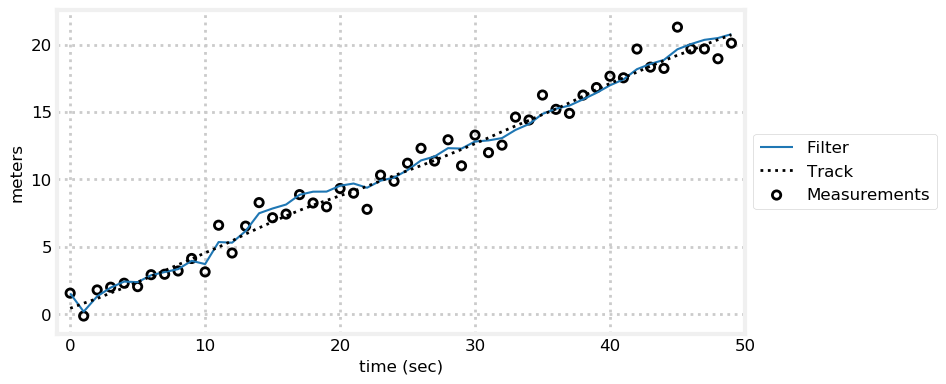

In [30]:
kf2 = SecondOrderKF(R, 0, dt=1)
data2 = filter_data(kf2, zs)
plot_kf_output(xs, data2.x, data2.z)

To my eye it looks like the filter quickly converges to the actual track. Success!

Or, maybe not. Setting the process noise to 0 tells the filter that the process model is perfect. Let's look at the performance of the filter over a longer period of time.

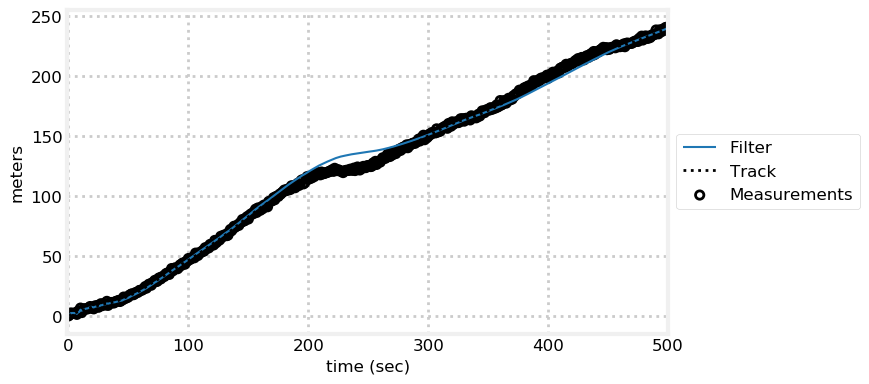

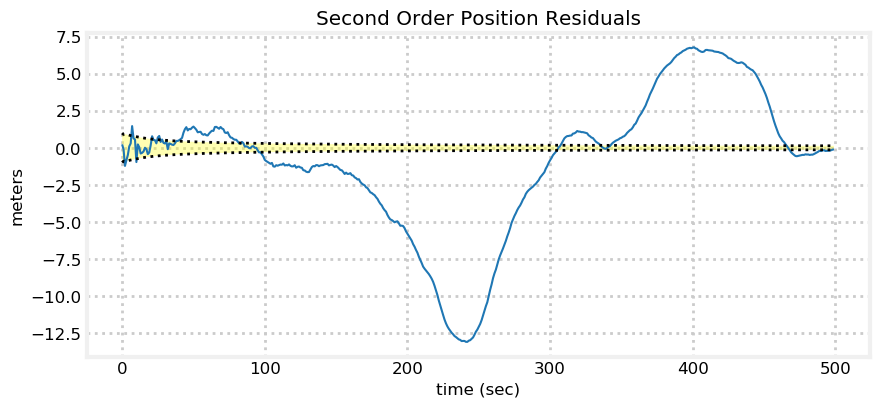

In [31]:
np.random.seed(25944)
xs500, zs500 = simulate_system(Q=Q, count=500)

kf2 = SecondOrderKF(R, 0, dt=1)
data500 = filter_data(kf2, zs500)

plot_kf_output(xs500, data500.x, data500.z)
plot_residuals(xs500[:, 0], data500, 0, 
               'Second Order Position Residuals',
               'meters') 

We can see that the performance of the filter is abysmal. We can see that in the track plot where the filter diverges from the track for an extended period of time.The residual plot makes the problem more apparent. Just before the 100th update the filter diverges sharply from the theoretical performance. It *might* be converging at the end, but I doubt it. The entire time, the filter is reporting smaller and smaller variances. **Do not trust the filter's covariance matrix to tell you if the filter is performing well**!

Why is this happening? Recall that if we set the process noise to zero we are telling the filter to use only the process model. The measurements end up getting ignored. The physical system is *not* perfect, and so the filter is unable to adapt to this imperfect behavior. 

Maybe just a really low process noise? Let's try that.

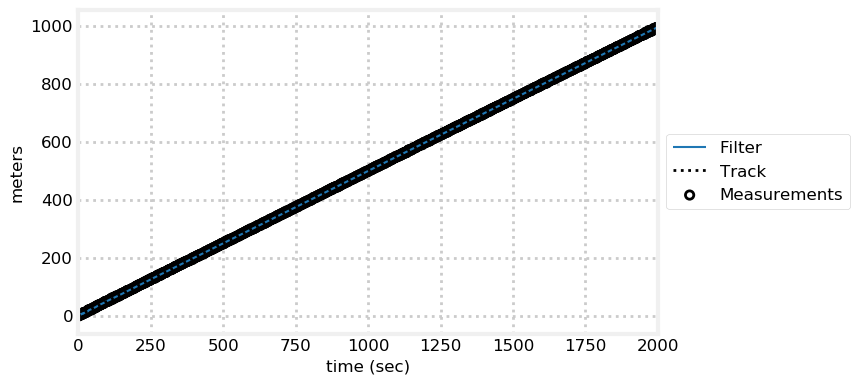

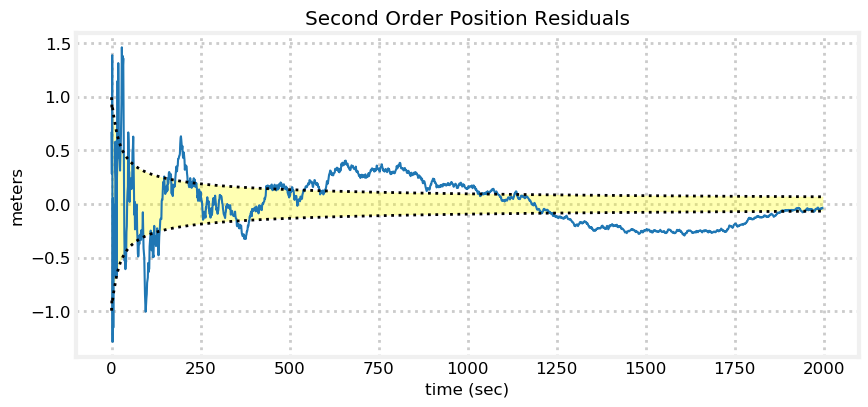

In [32]:
np.random.seed(32594)
xs2000, zs2000 = simulate_system(Q=0.0001, count=2000)

kf2 = SecondOrderKF(R, 0, dt=1)
data2000 = filter_data(kf2, zs2000)

plot_kf_output(xs2000, data2000.x, data2000.z)
plot_residuals(xs2000[:, 0], data2000, 0, 
               'Second Order Position Residuals',
               'meters') 

Again, the residual plot tells the story. The track looks very good, but the residual plot shows that the filter is diverging for significant periods of time.

How should you think about all of this? You might argue that the last plot is 'good enough' for your application, and perhaps it is. I warn you however that a diverging filter doesn't always converge. With a different data set, or a physical system that performs differently you can end up with a filter that veers further and further away from the measurements.

Also, let's think about this in a data fitting sense. Suppose I give you two points, and tell you to fit a straight line to the points. 

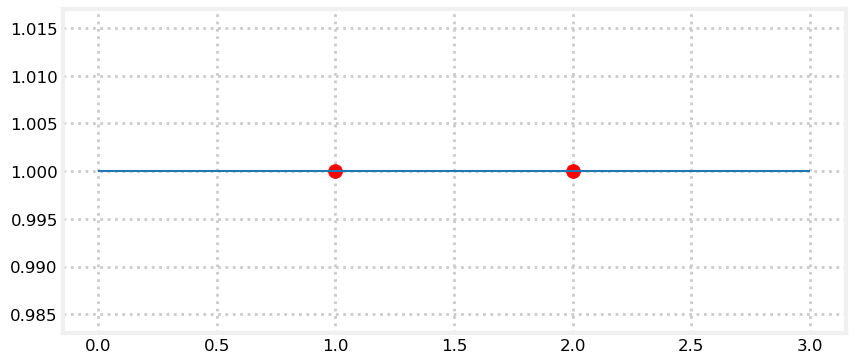

In [33]:
plt.scatter([1, 2], [1, 1], s=100, c='r')
plt.plot([0, 3], [1, 1]);

A straight line is the only possible answer. Furthermore, the answer is optimal. If I gave you more points you could use a least squares fit to find the best line, and the answer would still be optimal in a least squares sense.

But suppose I told you to fit a higher order polynomial to those two points. There are an infinite number of answers to the problem. For example, an infinite number of second order parabolas pass through those points. When the Kalman filter is of higher order than your physical process it also has an infinite number of solutions to choose from. The answer is not just non-optimal, it often diverges and never recovers. 

For best performance you need a filter whose order matches the system's order. In many cases that will be easy to do - if you are designing a Kalman filter to read the thermometer of a freezer it seems clear that a zero order filter is the right choice. But what order should we use if we are tracking a car? Order one will work well while the car is moving in a straight line at a constant speed, but cars turn, speed up, and slow down, in which case a second order filter will perform better. That is the problem addressed in the Adaptive Filters chapter. There we will learn how to design a filter that adapts to changing order in the tracked object's behavior.

With that said, a lower order filter can track a higher order process so long as you add enough process noise and you keep the discretization period small (100 samples a second are usually locally linear). The results will not be optimal, but they can still be very good, and I always reach for this tool first before trying an adaptive filter. Let's look at an example with acceleration. First, the simulation.

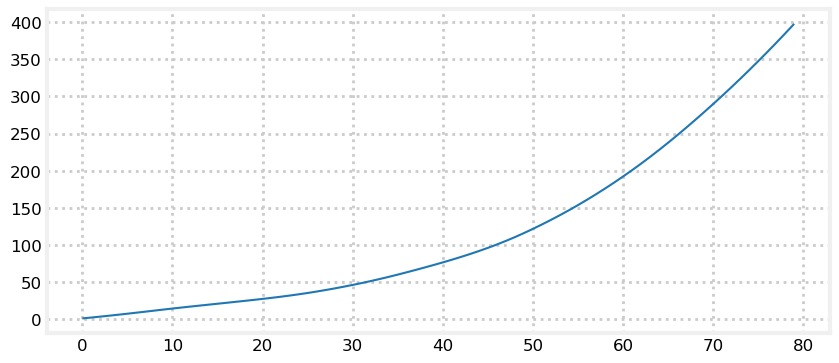

In [34]:
class ConstantAccelerationObject(object):
    def __init__(self, x0=0, vel=1., acc=0.1, acc_noise=.1):
        self.x = x0
        self.vel = vel
        self.acc = acc
        self.acc_noise_scale = acc_noise
    
    def update(self):
        self.acc += randn() * self.acc_noise_scale       
        self.vel += self.acc
        self.x += self.vel
        return (self.x, self.vel, self.acc)
  
R, Q = 6., 0.02
def simulate_acc_system(R, Q, count):
    obj = ConstantAccelerationObject(acc_noise=Q)
    zs = []
    xs = []
    for i in range(count):
        x = obj.update()
        z = sense(x, R)
        xs.append(x)
        zs.append(z)
    return np.asarray(xs), zs

np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)
plt.plot(xs[:, 0]);

Now we will filter the data using a second order filter.

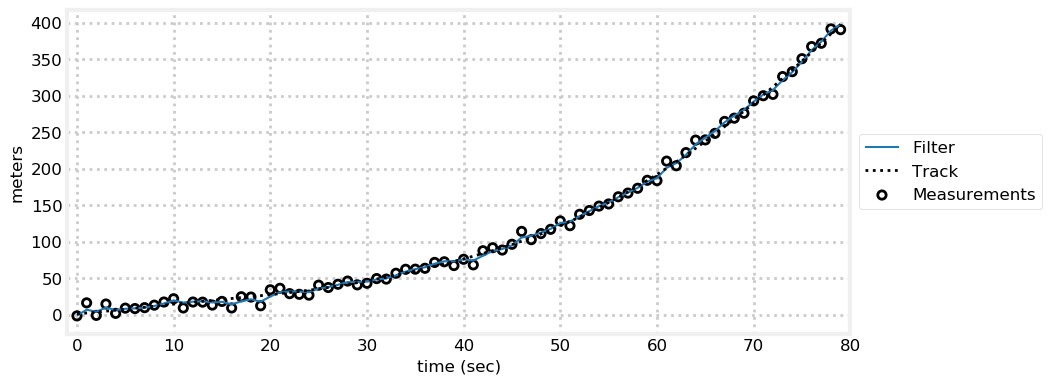

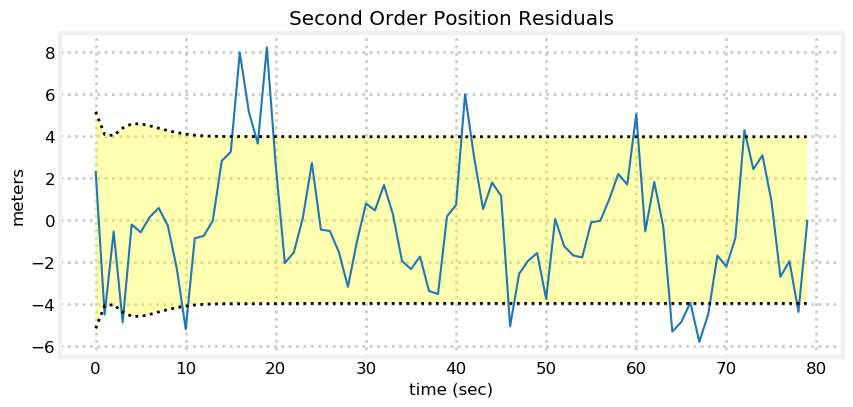

In [35]:
np.random.seed(124)
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)

kf2 = SecondOrderKF(R, Q, dt=1)
data2 = filter_data(kf2, zs)

plot_kf_output(xs, data2.x, data2.z, aspect_equal=False)
plot_residuals(xs[:, 0], data2, 0, 
               'Second Order Position Residuals',
               'meters') 

We can see that the filter is performing within the theoretical limits of the filter. 

Now let's use a lower order filter. As already demonstrated the lower order filter will lag the signal because it is not modeling the acceleration. However, we can account for that (to an extent) by increasing the size of the process noise. The filter will treat the acceleration as noise in the process model. The result will be suboptimal, but if designed well it will not diverge. Choosing the amount of extra process noise is not an exact science. You will have to experiment with representative data. Here, I've multiplied it by 10, and am getting good results.

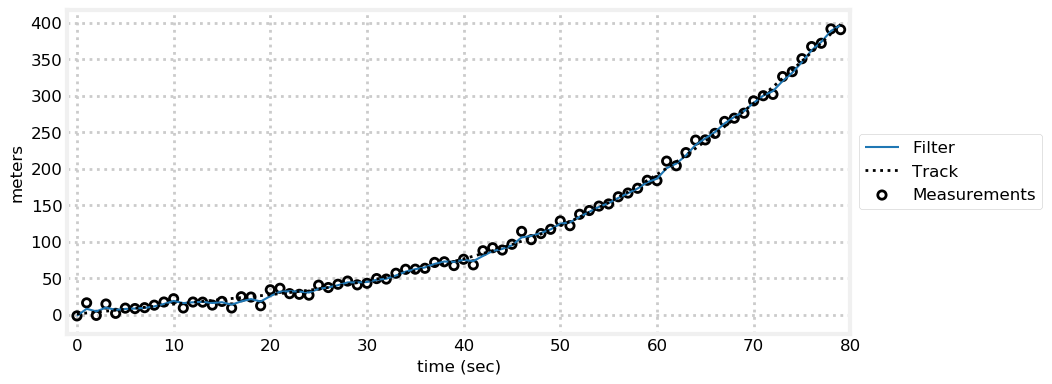

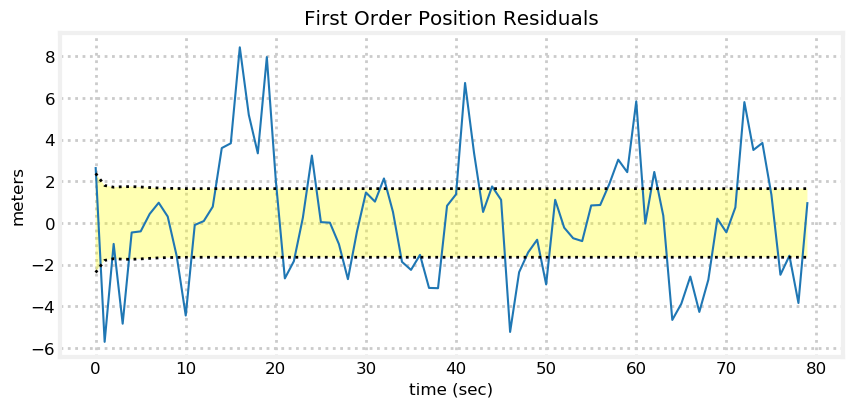

In [36]:
kf3 = FirstOrderKF(R, Q * 10, dt=1)
data3= filter_data(kf3, zs)

plot_kf_output(xs, data3.x, data3.z, aspect_equal=False)
plot_residuals(xs[:, 0], data3, 0, 
               'First Order Position Residuals',
               'meters') 

Think about what will happen if you make the process noise many times larger than it needs to be. A large process noise tells the filter to favor the measurements, so we would expect the filter to closely mimic the noise in the measurements. Let's find out.

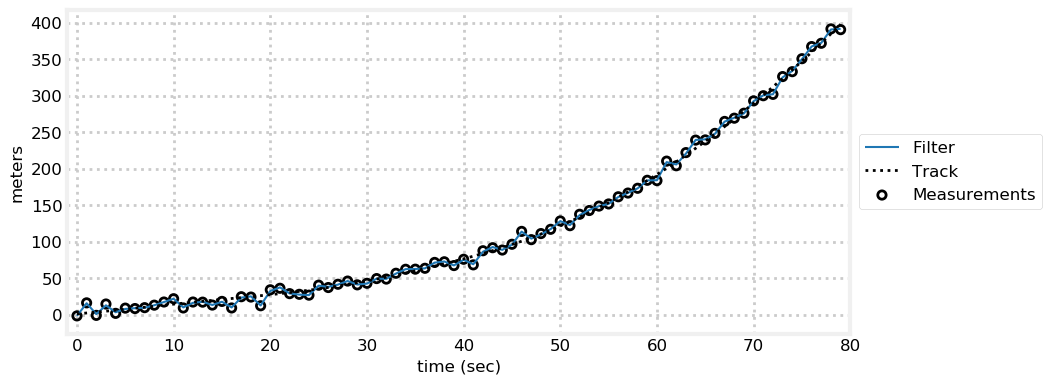

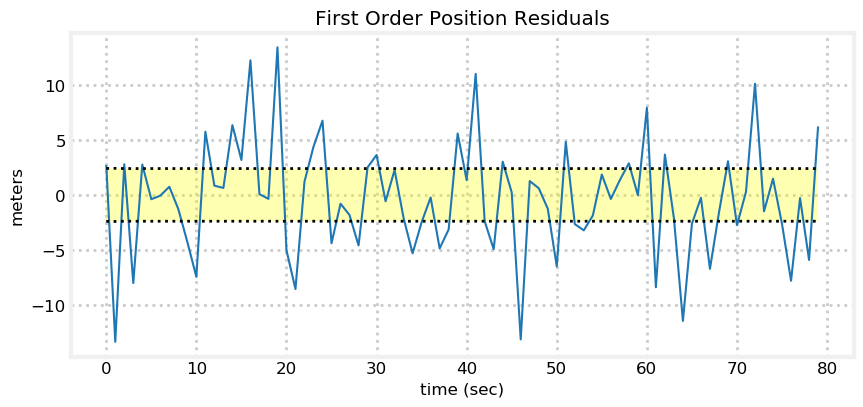

In [37]:
kf4 = FirstOrderKF(R, Q * 10000, dt=1)
data4 = filter_data(kf4, zs)

plot_kf_output(xs, data4.x, data4.z, aspect_equal=False)
plot_residuals(xs[:, 0], data4, 0, 
               'First Order Position Residuals',
               'meters') 

## Exercise: State Variable Design

As I've mentioned, you may place the variables in $\mathbf x$ in whatever order you choose. For example, you could define a 1D constant acceleration as $\mathbf x = \begin{bmatrix}\ddot x & x & \dot x\end{bmatrix}^\mathsf T$. I can't imagine why you would want that order, but it is possible.

Let's do something more reasonable. Design a second order filter for a robot moving in 2D, where $\mathbf x = \begin{bmatrix}x & y & \dot x & \dot y \end{bmatrix}^\mathsf T$. In this chapter we have been using $\mathbf x = \begin{bmatrix}x & \dot x & y & \dot y \end{bmatrix}^\mathsf T$.

Why would you choose a different ordering? As you'll see in a moment, changing the order of $\mathbf x$ changes the order of most of the rest of the filter's matrices. Depending on what data you want to inspect, such as the correlations in $\mathbf P$, various orderings of $\mathbf x$ can make that easier or more difficult.

Think about how to do this. What needs to change? Clearly, you just need to change the Kalman filter matrices to reflect this new design. 

Give it a try below using this boilerplate code:

```python

N = 30 # number of iterations
dt = 1.0 # time step
R_std = 0.35
Q_std = 0.04

sensor = PosSensor((0, 0), (2, .5), noise_std=R_std)
zs = np.array([sensor.read() for _ in range(N)])

tracker = KalmanFilter(dim_x=4, dim_z=2)
# assign state variables here

xs, ys = [], []
for z in zs:
    tracker.predict()
    tracker.update(z)
    xs.append(tracker.x[0])
    ys.append(tracker.x[1])
plt.plot(xs, ys);
```

### Solution

Let's start with $\mathbf F$. With a bit of practice you should be able to just write out the matrix. If you found that difficult, then write out the set of equations for $\mathbf F$ ordering the variables as used by the state variable.

$$
x = 1x + 0y + 1\dot x\Delta t + 0 \dot y\Delta t \\
y = 0x + 1y + 0\dot x\Delta t + 1 \dot y\Delta t \\
\dot x = 0x + 0y + 1\dot x\Delta t + 0 \dot y\Delta t \\
\dot y = 0x + 0y + 0\dot x\Delta t + 1 \dot y\Delta t 
$$

We can copy out the coefficients to get

$$\mathbf F = \begin{bmatrix}1&0&\Delta t & 0\\0&1&0&\Delta t\\0&0&1&0\\0&0&0&1\end{bmatrix}$$

The state noise also requires shuffling things around. First, figure out how it should be arranged for the state variable ordering. This can be easier if you write the state variables vertically and horizontally across the matrix to see how they pair up. This is hard to do in Jupyter notebook, so I will forgo it here.

$$\mathbf Q = 
\begin{bmatrix}
\sigma_x^2 & \sigma_{xy} & \sigma_{x\dot x} & \sigma_{x\dot y} \\
\sigma_{yx} & \sigma_y^2 & \sigma_{y\dot x} & \sigma_{y\dot y} \\
\sigma_{\dot x x} & \sigma_{\dot x y} & \sigma_{\dot x}^2 & \sigma_{\dot x \dot y} \\
\sigma_{\dot y x} & \sigma_{\dot y y} & \sigma_{\dot y \dot x} & \sigma_{\dot y}^2
\end{bmatrix}
$$

There is no correlation between $x$ and $y$, so we can set terms with both to zero

$$\mathbf Q = 
\begin{bmatrix}
\sigma_x^2 & 0 & \sigma_{x\dot x} & 0 \\
0 & \sigma_y^2 & 0 & \sigma_{y\dot y} \\
\sigma_{\dot x x} & 0 & \sigma_{\dot x}^2 & 0 \\
0 & \sigma_{\dot y y} & 0 & \sigma_{\dot y}^2
\end{bmatrix}
$$

Now that you see this you can see the pattern and perhaps design $\mathbf Q$ more quickly.

`Q_discrete_white_noise` generates a matrix with a different ordering, but we can just copy terms from it, which we will see in the code below.

Now let's design $\mathbf H$. It converts the state $\begin{bmatrix}x & y & \dot x & \dot y \end{bmatrix}^\mathsf T$ into the measurement $\mathbf z = \begin{bmatrix}z_x & z_y\end{bmatrix}^\mathsf T$.

$$
\begin{aligned}
\mathbf{Hx} &= \mathbf z \\
\begin{bmatrix}?&?&?&?\\?&?&?&?\end{bmatrix}\begin{bmatrix}x \\ y \\ \dot x \\ \dot y \end{bmatrix} &= \begin{bmatrix}z_x \\ z_y\end{bmatrix}
\end{aligned}
$$

Now it should be easy to fill in the matrix:
$$
\begin{bmatrix}1&0&0&0\\0&1&0&0\end{bmatrix}\begin{bmatrix}x \\ y \\ \dot x \\ \dot y \end{bmatrix} = \begin{bmatrix}z_x \\ z_y\end{bmatrix}
$$

The measurement $\mathbf z = \begin{bmatrix}z_x & z_y\end{bmatrix}^\mathsf T$ has not changed so $\mathbf R$ does not change.

Finally, $\mathbf P$. It uses the same ordering as $\mathbf Q$, so it is already designed for us.

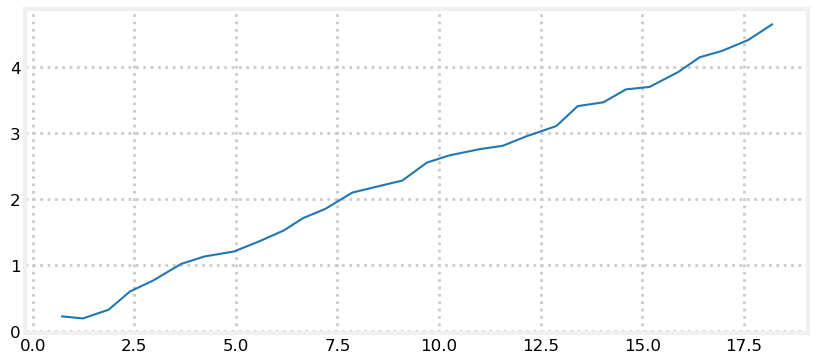

In [38]:
N = 30 # number of iterations
dt = 1.0 # time step
R_std = 0.35
Q_std = 0.04

M_TO_FT = 1 / 0.3048

sensor = PosSensor((0, 0), (2, .5), noise_std=R_std)
zs = np.array([sensor.read() for _ in range(N)])

tracker = KalmanFilter(dim_x=4, dim_z=2)

tracker.F = np.array([[1, 0, dt,  0],
                      [0, 1,  0, dt],
                      [0, 0,  1,  0],
                      [0, 0,  0,  1]])

tracker.H = np.array([[M_TO_FT, 0, 0, 0],
                      [0, M_TO_FT, 0, 0]])

tracker.R = np.eye(2) * R_std**2
q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2)
tracker.Q[0,0] = q[0,0]
tracker.Q[1,1] = q[0,0]
tracker.Q[2,2] = q[1,1]
tracker.Q[3,3] = q[1,1]
tracker.Q[0,2] = q[0,1]
tracker.Q[2,0] = q[0,1]
tracker.Q[1,3] = q[0,1]
tracker.Q[3,1] = q[0,1]

tracker.x = np.array([[0, 0, 0, 0]]).T
tracker.P = np.eye(4) * 500.

xs, ys = [], []
for z in zs:
    tracker.predict()
    tracker.update(z)
    xs.append(tracker.x[0])
    ys.append(tracker.x[1])
plt.plot(xs, ys);

## Detecting and Rejecting Bad Measurement

The Kalman filter provides no way to detect and reject a bad measurement. Suppose you are tracking aircraft, and you receive a measurement 100km away from the aircraft's current position. If you call update with that value the new estimate will be skewed radically towards the measurement.

I'll run a simulation to give us a concrete example. After 100 epoch's I'll do an update with a measurement equal to twice the current position. `filterpy.common` provides `kinematic_kf` which creates a linear kinematic filter of arbitrary dimension and order. I'll use it here to keep the code tidy, I don't use it in the rest of the book because I want you to get lots of practice writing filters.

In [39]:
from filterpy.common import kinematic_kf

kf = kinematic_kf(dim=2, order=1, dt=1.0, order_by_dim=False)
kf.Q = np.diag([0, 0, .003, .003])
kf.x = np.array([[1., 1., 0., 0.]]).T
kf.R = np.diag([0.03, 0.21]) # use different errors

for i in range(101):
    kf.predict()
    kf.update(np.array([[i*.05, i*.05]])) # around 200 kph

p0 = kf.x[0:2]

kf.predict()
prior = kf.x
z = kf.x[0:2]*2
kf.update(z)
p1 = kf.x[0:2]

# compute error of measurement from prior
y = np.abs(z - np.dot(kf.H, prior))
dist = np.linalg.norm(y)

np.set_printoptions(precision=2, suppress=True)

print('bad measurement       : {} km'.format(z.T))
print('before bad measurement: {} km'.format(p0.T))
print('after bad measurement : {} km'.format(p1.T))
print('estimate shift        : {:.1f} km'.format(np.linalg.norm(p1 - prior[:2])))
print('distance from prior   : {:.1f} km'.format(dist))


bad measurement       : [[10.1 10.1]] km
before bad measurement: [[5. 5.]] km
after bad measurement : [[7.84 7.01]] km
estimate shift        : 3.4 km
distance from prior   : 7.1 km


`kinematic_kf`? What's that? `filterpy.common` provides `kinematic_kf` to allow you to create a linear kinematic filter of arbitrary dimension and order. I don't use it in this book because I want you to gain a lot of experience creating Kalman filters. I used it here just to keep my example short and to expose you to this part of the library.

Back on topic. As you can see the estimate jumped 3.4 km, and the error between the prediction (prior) and the measurement is over 7 km.

What can we do to avoid this? Our first thought might be to just add a check if the prior is far from the measurement. Why the prior and not the current estimate? Because after the update the estimate could now be quite close to the bad measurement, although it isn't in this case.

Note that while I could have just written `prior[0:2] - z` to get the error, I used the mathematically correct $\mathbf z - \mathbf{Hx}$ to compute the error. This is just for illustration; the Kalman filter class stores the innovation in `KalmanFilter.y`. I use it instead of the value I computed above to illustrate this:

In [40]:
print('error = {:.1f} km, at a speed of {:.0f} kph'.format(np.linalg.norm(kf.y), dist*3600))

error = 7.1 km, at a speed of 25710 kph


In this example the measurement is nearly 7 km away from the predicted position. That sounds "far". Is it? It could be far if the units are kilometers and the update rate is 1 second; no aircraft can travel the over 25000 kph this error implies. It could be absurdly small if the units are centimeters and the epoch is 1 minute.

We could add a check that either takes the performance limits of the aircraft into account:
```
vel = y / dt
if vel >= MIN_AC_VELOCITY and vel <= MAX_AC_VELOCITY:
    kf.update()
```
 
Do you think this is a reasonable and robust solution? Come up with as many objections as you can before reading further.


This is not very satisfying to me. Suppose we had just initialized the filter with an guessed at position; we would discard good measurements and never start filtering. Second, this ignores the knowledge we have about the sensor and process errors. The Kalman filter maintains its current accuracy in $\mathbf P$. If $\mathbf P$ implies that $\sigma_x = 10$ meters, and the measurement is 1 km away, clearly the measurement is bad as it is 100 standard deviations away from the prior. 

Let's plot $\mathbf P$. I'll plot the first, second, and third standard deviations.

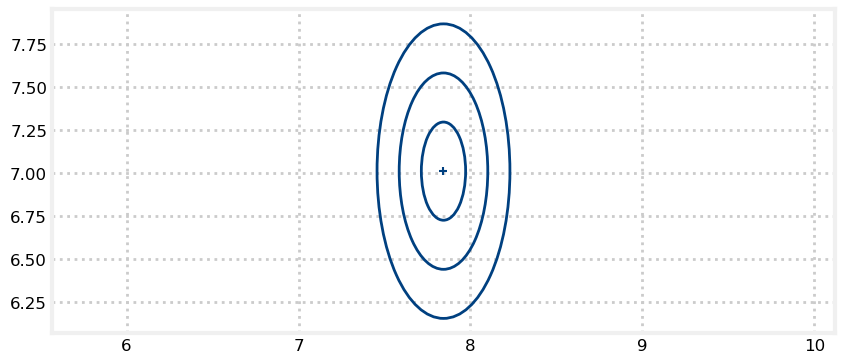

In [41]:
x, P = kf.x[0:2], kf.P[0:2, 0:2]
plot_covariance_ellipse(x, P, std=[1,2,3])

In previous sections $\mathbf P$ was a cicle, not an ellipse. In my code I set  $\mathbf R = \bigl[ \begin{smallmatrix}0.03 & 0 \\ 0 & 0.15\end{smallmatrix}\bigl ]$, which gives the measurement of $y$ 5 times the error of $x$. That's somewhat artificial, but in subsequent chapters nearly all of the covariances will be elliptical for good reasons. 

Think about what this means. Statistics tells us that 99% of all measurements fall within 3 standard deviations; that means 99% of all measurements should be within this ellipse. Let's plot the measurement with the ellipse.

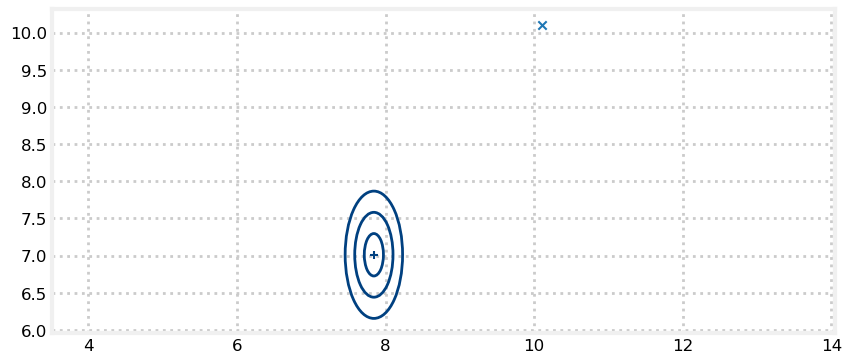

In [42]:
plot_covariance_ellipse(x, P, std=[1,2,3])
plt.scatter(z[0], z[1], marker='x');

Clearly the measurement is far beyond the the prior's covariance; we probably want to consider this a bad measurement and not use it. How would we do that?

The first idea would to be extract the standard deviation for $x$ and $y$ and write a simple if statement. Here I will use another feature of the `KalmanFilter` class. The method `residual_of` computes the residual compared to the prior. I don't need to use it in this case since `kf.y` is already assigned by the call to `update()`, but if we are discarding measurements `update()` would not have been called yet and `kf.y` would contain the innovation from the previous epoch.

First, let's introduce two terms. We are discussing **gating**. A **gate** is a formula or algorithm that determines if a measurement is good or bad. Only good measurements get through the gate. This process is called gating.

In practice measurements are not purely Gaussian, so a gate of 3 standard deviations is likely to discard some good measurements. I will elaborate soon, for now we will use 4 standard deviations

In [43]:
GATE_LIMIT = 4.
std_x = np.sqrt(P[0,0])
std_y = np.sqrt(P[1,1])
y = kf.residual_of(z)[:,0]

if y[0] > GATE_LIMIT * std_x or y[1] > GATE_LIMIT * std_y:
    print('discarding measurement, error is {:.0f} std, {:.0f} std'.format(y[0]/std_x, y[1]/std_y))
    
print('y   is', y)
print('std is {:.2f} {:.2f}'.format(std_x, std_y))

discarding measurement, error is 39 std, 18 std
y   is [5.05 5.05]
std is 0.13 0.29


We see the errors are roughly 39 and 18 standard deviations away. Is this good enough?

Maybe. However, notice that the if statement forms a rectangular region surrounding the ellipse. In the plot below I've drawn a measurement that is clearly outside of the 3 std ellipse, yet would be accepted by the gate, and another measurement that lies just on the 3 std boundary.

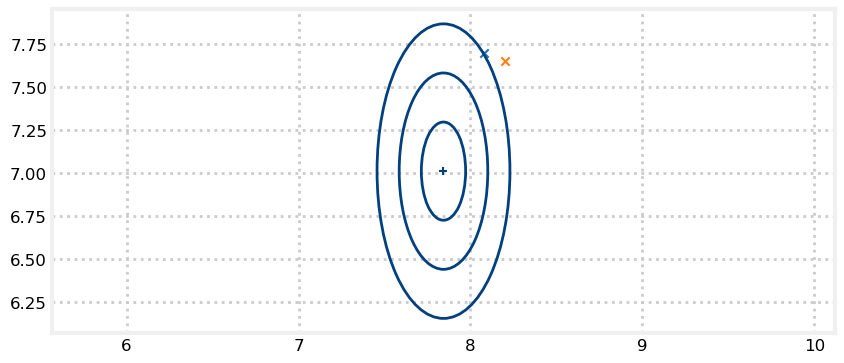

In [44]:
plot_covariance_ellipse(x, P, std=[1,2,3])
plt.scatter(8.08, 7.7, marker='x');
plt.scatter(8.2, 7.65, marker='x');

There are alternative methods of defining this gate. The **mahalanobis distance** is a statistical measure of the distance of a point from a distribution. Before we get to the definition and math, let's compute the mahalanobis distance for some points. `filterpy.stats` implements `mahalanobis()`.

In [45]:
from filterpy.stats import mahalanobis

print('mahalanobis distance = {:.1f}'.format(mahalanobis(x=z, mean=x, cov=P)))

mahalanobis distance = 20.6


Without knowing the units we can compare it to the standard deviation errors computed in $x$ and $y$ separately, 39, and 18, and see that it is reasonably close. Let's see what we get for the point I plotted above.

In [46]:
print('mahalanobis distance = {:.1f}'.format(mahalanobis(x=[8.08, 7.7], mean=x, cov=P)))
print('mahalanobis distance = {:.1f}'.format(mahalanobis(x=[8.2, 7.65], mean=x, cov=P)))

mahalanobis distance = 3.0
mahalanobis distance = 3.6


As we will see the mahalanobis distance computes the scalar standard deviation *distance* point to a distribution, much like the Euclidian distance computes a scalar distance from a point to another point. 

The cell above bears that out. The point that was sitting on the 3 std boundary has a mahalanobis distance of 3.0, and the one outside of the ellipse has a value of 3.6 std.

How do we compute the mahalanobis distance? It is defined as

$$D_m= \sqrt{(\mathbf x-\mu)^\mathsf T \mathbf S^{-1} (\mathbf x-\mu)}$$

Note how similar this is to the Euclidean distance, which we can write as:

$$D_e= \sqrt{(\mathbf x-\mathbf y)^\mathsf T (\mathbf x-\mathbf y)}$$

In fact, if the covariance $\mathbf S$ is the identity matrix the mahalanobis distance is the same as the Euclidean distance. You should be able to see how that works with the linear algebra: the inverse of the identity matrix is the identity matrix, so we are effectively multiplying the terms with 1. Think of it intuitively. If the standard deviation in each dimension is 1, then the a point anywhere on a circle of radius 1 around the mean will lie on the 1 std circle and also be 1 *unit* away in Euclidean measure.

This suggests another interpretation. If the covariance matrix is diagonal then we can think of the mahalanobis distance as being the *scaled* Euclidean distance, where each term is scaled by the covariance in the diagonal.

$$D_m = \sqrt{\sum_{i-1}^N \frac{(x_i - \mu_i)^2}{\sigma_i}}$$

In 2D that would be 

$$D_m = \sqrt {\frac{1}{\sigma_x^2}(x_0 - x_1)^2 + \frac{1}{\sigma_y^2}(y_0 - y_1)^2}$$

This should give you insight into the equation for mahalanobis distance. You cannot divide by a matrix, but multiplying by the inverse is *effectively* the same, in a hand wavey sense. Multiplying by the difference $\mathbf y = \mathbf x - \mathbf \mu$ on each side gives us the squared norm scaled by the covariance: $\mathbf y^\mathsf T \mathbf S^{-1}\mathbf y^\mathsf T$. The covariance terms are all squared, so taking the square root at the end brings us to a scalar distance which is the Euclidean distance scaled by the covariance.


### Gating and Data Association Strategies

The two gates above are known as rectangular and ellipsoidal gates in some of the literature because of their shape. There are more alternatives I will not explore here. For example, a maneuver gate is used to define a region where it is possible for the object to maneuver, taking the object's current velocity and ability to maneuver into account. For example, a fighter jet would have a maneuver gate shaped much like a cone projecting in front of it's current direction of travel. An automobile would have a much smaller 2D pie slice shape projecting in front of it. A ship would have a much narrower slice since it's ability to turn or accelerate quickly is minimal.

Which gating technique should you use? There is no single answer. Much depends on the dimensionality of the problem and how much computational power you have. A rectangular gate is very cheap to compute, the maneuver gate isn't much worse, but the ellipsoidal gate can be expensive in higher dimensions. However, as you increase dimensions the relative area difference between the ellipsoid and rectangular gate increases significantly.

This matters more than you might realize. Every measurement has noise. A spurious measurement can fall *within* our gate, causing us to accept it. The larger the area that extends past the ellipsoid, the larger the probability of the gate passing a bad measurement. I will not do the math here, but in 5 dimensions the rectangular gate is twice as likely to accept a bad measurement as the ellipsoid. 

If computational time is a concern and you have many spurious measurements you can take a two gate approach. The first gate is large and rectangular, and used as a first pass to throw away obviously bad measurements. The few measurements that pass that gate are then subjected to the more expensive mahalanobis distance calculation. If you are running on a modern desktop processor the time of those matrix multiplies are not significant, but it may matter if you are running on an embedded chip with modest floating point performance.

Data association is a vast topic that requires its own book. The canonical example is tracking with radar. The radar detects multiple signals on each sweep. From that we need to form aircraft tracks, and reject noisy measurements. This is a very difficult problem. Suppose the first sweep gets 5 measurements. We would create 5 potential tracks. In the next sweep we get 6 measurements. We can combine any of the first measurements with any of the second measurements, giving us 30 potential tracks. But, it is also possible that these are all new aircraft that we didn't see in the last sweep, so that gives us 6 more tracks. After just a few epochs we reach millions, then billions of potential tracks.

Given this list of billions of tracks we can then compute a score for each track. I'll provide the math for that in the following section. But, visualize a track that forms a 'Z' shape over 3 epochs. No aircraft can maneuver like that, so we would give it a very low probability of being real. Another track forms a straight line, but imputes a velocity of 10,000 kph. That is also very improbable. Another track curves at 200 kph. That has a high probability.

So tracking becomes a matter of gating, data association, and pruning. For example, say the second radar sweep just occured. Do I combine all possible combinations into a tracks? I probably shouldn't. If point 1, sweep 1 imputes a velocity of 200kph with point 3, sweep 2 we should form a track from it. If the velocity is 5000 kph we shouldn't bother; we know that track is so unlikely as to be impossible. Then, as the tracks grow we will have well defined ellipsoidal or maneuver gates for them, and we can be far more selective about the measurements we associate with tracks.

There are schemes for associations. We can choose to associate a measurement to only one track. Or, we can choose to associate a measurement with multiple tracks, reflecting our lack of certainty with which track it belongs to. For example, aircraft tracks can cross from the point of view of the radar. As the aircraft approach associating a single measurement with one of the two aircraft can become uncertain. You could assign the measurement to both tracks for a short time. As you gather more measurements you could then go back and change assignment based on which is more probable given the new information.

'Billions' does not begin to capture the combinatorial explosion this implies. After just a few seconds you will be out of computer memory, a bit longer and you would require every atom in the universe to represent all of the potential tracks. So a practical algorithm needs to aggressively prune tracks. This pruning takes additional compute power. 

A later chapter in the book provides the modern answer to this problem, the *particle filter*, which solves the combinatorial explosion with statistical sampling. It is my favored approach for this problem, so I will not write more about the techniques I am discussing in this section. I am not entirely up to date on current research in this area, so do your own research if you are trying to solve a problem requiring to either track multiple objects or deal with multiple spurious measurements. Particle filters have their own difficulties and limitations.

I will point you to a few books and researchers. Samuel S. Blackman's "Multiple-Target Tracking with Radar Application" is the clearest written book I have read on the topic, though it is dated (1986). Yaakov Bar-Shalom has written extensively on the subject. Subhash Challa et. al "Fundamentals of Object Tracking" is a fairly modern work that covers the various approaches. This book is fairly rigorous mathematically; filters are presented as a collection of integrals representing various Bayesian formulation, and it is up to you to translate that into a working algorithm. It is readable if you have taken on all the math in this book, but not easy. Lawrence D. Stone's "Bayesian Multiple Target Tracking" treats it as a Bayesian inference problem, as I have, but is also quite theoretical, where you are blithely told to find a maximum of a complicated integral, which in practice you will probably solve using a particle filter. 

Back to our simple problem - tracking a single object with an occasional bad measurement. How should that be implemented? It's fairly straightforward; if the measurement is bad, discard it and do not call update. This will cause you to call `predict()` twice in a row, which is fine. Your uncertainty will grow, but a few missed updates generally will not cause a problem. 

What cutoff value should you use for your gate? I don't know. Theory says 3 std, but practice says otherwise. You will need to experiment. Gather data, run a filter on it using various gates, and see what value gives the best results. In the next section I give you some math to evaluate filter performance. Maybe you find out you need to accept all measurements < 4.5 std. I watched a NASA video where they stated they used a gate around 5-6 std. it depends on your problem and data. 

## Evaluating Filter Performance

It is easy to design a Kalman filter for a simulated situation. You know how much noise you are injecting in your process model, so you specify $\mathbf Q$ to have the same value. You also know how much noise is in the measurement simulation, so the measurement noise matrix $\mathbf R$ is equally trivial to define. 

In practice design is more ad hoc. Real sensors rarely perform to spec, and they rarely perform in a Gaussian manner. They are also easily fooled by environmental noise. For example, circuit noise causes voltage fluctuations which can affect the output of a sensor. Creating a process model and noise is even more difficult. Modelling an automobile is very difficult. The steering causes nonlinear behavior, tires slip, people brake and accelerate hard enough to cause tire slips, winds push the car off course. The end result is the Kalman filter is an *inexact* model of the system. This inexactness causes suboptimal behavior, which in the worst case causes the filter to diverge completely. 

Because of the unknowns you will be unable to analytically compute the correct values for the filter's matrices. You will start by making the best estimate possible, and then test your filter against a wide variety of simulated and real data. Your evaluation of the performance will guide you towards what changes you need to make to the matrices. We've done some of this already - I've shown you the effect of $\mathbf Q$ being too large or small.

Now let's consider more analytical ways of accessing performance. If the Kalman filter is performing optimally its estimation errors (the difference between the true state and the estimated state) will have these properties:

    1. The mean of the estimation error is zero
    2. Its covariance is described by the Kalman filter's covariance matrix
    
### Normalized Estimated Error Squared (NEES)

The first method is the most powerful, but only possible in simulations. If you are simulating a system you know its true value, or 'ground truth'. It is then trival to compute the error of the system at any step as the difference between ground truth ($\mathbf x$) and the filter's state estimate ($\hat{\mathbf x}$):

$$\tilde{\mathbf x} = \mathbf x - \hat{\mathbf x}$$

We can then define the *normalized estimated error squared* (NEES) as 

$$\epsilon = \tilde{\mathbf x}^\mathsf T\mathbf P^{-1}\tilde{\mathbf x}$$

To understand this equation let's look at it if the state's dimension is one. In that case both x and P are scalars, so

$$\epsilon = \frac{x^2}{P}$$

If this is not clear, recall that if $a$ is scalar,  $a^\mathsf T = a$ and that $a^{-1} =\frac{1}{a}$.

So as the covariance matrix gets smaller NEES gets larger for the same error. The covariance matrix is the filter's estimate of it's error, so if it is small relative to the estimation error then it is performing worse than if it is large relative to the same estimation error.

This computation gives us a scalar result. If $\mathbf x$ is dimension ($n \times 1$), then the dimension of the computation is ($1 \times n$)($n \times n$)($n \times 1$) = ($1 \times 1$). What do we do with this number?

The math is outside the scope of this book, but a random variable in the form $\tilde{\mathbf x}^\mathsf T\mathbf P^{-1}\tilde{\mathbf x}$ is said to be *chi-squared distributed with n degrees of freedom*, and thus the expected value of the sequence should be $n$. Bar-Shalom [1] has an excellent discussion of this topic. 

In plain terms, take the average of all the NEES values, and they should be less then the dimension of x. Let's see that using an example from earlier in the chapter:

In [47]:
from scipy.linalg import inv

def NEES(xs, est_xs, Ps):
    est_err = xs - est_xs
    err = []
    for x, p in zip(est_err, Ps):
        err.append(np.dot(x.T, inv(p)).dot(x))
    return err

In [48]:
R, Q = 6., 0.02
xs, zs = simulate_acc_system(R=R, Q=Q, count=80)
kf2 = SecondOrderKF(R, Q, dt=1)
est_xs, ps, _, _ = kf2.batch_filter(zs)

nees = NEES (xs, est_xs, ps)
eps = np.mean(nees)

print('mean NEES is: ', eps)
if eps < kf2.dim_x:
    print('passed')
else:
    print('failed')

mean NEES is:  0.8893319389009477
passed


`NEES` is implemented FilterPy; access it with

```python
from filterpy.stats import NEES
```
This is an excellent measure of the filter's performance, and should be used whenever possible, especially in production code when you need to evaluate the filter while it is running. While designing a filter I still prefer plotting the residauls as it gives me a more intuitive understand what is happening.

However, if your simulation is of limited fidelity then you need to use another approach.

### Likelihood Function

In statistics the likelihood is very similar to a probability, with a subtle difference that is important to us. A *probability* is the chance of something happening - as in what is the probability that a fair die rolls 6 three times in five rolls? The *likelihood* asks the reverse question - given that a die rolled 6 three times in five rolls, what is the likelihood that the die is fair?  

We first discussed the likelihood function in the **Discrete Bayes** chapter. In the context of these filters the likelihood is a measure of how likely the measurement are given the current state.

This is important to us because we have the filter output and we want to know the likelihood that it is performing optimally given the assumptions of Gaussian noise and linear behavior. If the likelihood is low we know one of our assumptions is wrong. In the **Adaptive Filtering** chapter we will learn how to make use of this information to improve the filter; here we will only learn to make the measurement. 

The residual and system uncertainty of the filter is defined as

$$\begin{aligned}
\mathbf y &= \mathbf z - \mathbf{H \bar x}\\
\mathbf S &= \mathbf{H\bar{P}H}^\mathsf T + \mathbf R
\end{aligned}
$$

Given these we can compute the likelihood function with

$$
\mathcal{L} = \frac{1}{\sqrt{2\pi S}}\exp [-\frac{1}{2}\mathbf y^\mathsf T\mathbf S^{-1}\mathbf y]$$

That may look complicated, but notice that the exponential is the equation for a Gaussian. This suggests an implementation of

```python
from scipy.stats import multivariate_normal
hx = np.dot(H, x).flatten()
S = np.dot(H, P).dot(H.T) + R
likelihood = multivariate_normal.pdf(z.flatten(), mean=hx, cov=S)
```

In practice it happens a bit differently. Likelihoods can be difficult to deal with mathmatically. It is common to compute and use the *log-likelihood* instead, which is just the natural log of the likelihood. This has several benefits. First, the log is strictly increasing, and it reaches it's maximum value at the same point of the function it is applied to. If you want to find the maximum of a function you normally take the derivative of it; it can be difficult to find the derivative of some arbitrary function, but finding $\frac{d}{dx} log(f(x))$ is trivial, and the result is the same as $\frac{d}{dx} f(x)$. We don't use this property in this book, but it is essential when performing analysis on filters.

The likelihood and log-likelihood are computed for you when `update()` is called, and is accessible via the 'log_likelihood' and `likelihood` data attribute. Let's look at this: I'll run the filter with several measurements within expected range, and then inject measurements far from the expected values:

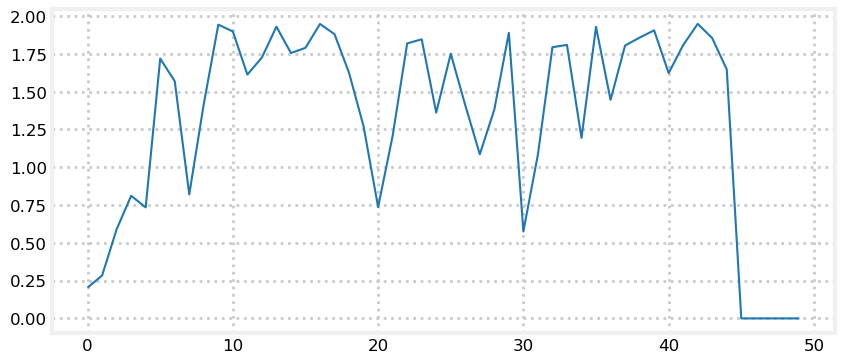

In [49]:
R, Q = .05, 0.02
xs, zs = simulate_acc_system(R=R, Q=Q, count=50)
zs[-5:-1] = [100, 200, 200, 200] # bad measurements, bad!

kf = SecondOrderKF(R, Q, dt=1, P=1)
s = Saver(kf)
kf.batch_filter(zs, saver=s)
plt.plot(s.likelihood);

The likelihood gets larger as the filter converges during the first few iterations. After that the likelihood bounces around until it reaches the bad measurements, at which time it goes to zero, indicating that if the measurements are valid the filter is very unlikely to be optimal.

See how starkly the log-likelihood illustrates where the filter goes 'bad'.

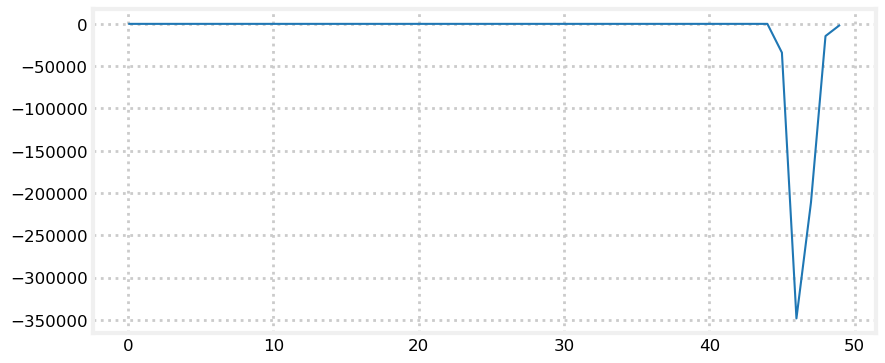

In [50]:
plt.plot(s.log_likelihood);

Why does it return to zero at the end? Think about that before reading the answer. The filter begins to adapt to the new measurements by moving the state close to the measurements. The residuals become small, and so the state and residuals agree. 

## Control Inputs

In the **Discrete Bayes** chapter I introduced the notion of using control signals to improve the filter's performance. Instead of assuming that the object continues to move as it has so far we use our knowledge of the control inputs to predict where the object is. In the **Univariate Kalman Filter** chapter we made use of the same idea. The predict method of the Kalman filter read

```python
def predict(pos, movement):
    return (pos[0] + movement[0], pos[1] + movement[1])
```

In the last chapter we learned that the equation for the state prediction is:

$$\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}$$

Our state is a vector, so we need to represent the control input as a vector. Here $\mathbf{u}$ is the control input, and $\mathbf{B}$ is a matrix that transforms the control input into a change in $\mathbf x$. Let's consider a simple example. Suppose the state is $x = \begin{bmatrix} x & \dot x\end{bmatrix}$ for a robot we are controlling and the control input is commanded velocity. This gives us a control input of 

$$\mathbf{u} = \begin{bmatrix}\dot x_\mathtt{cmd}\end{bmatrix}$$

For simplicity we will assume that the robot can respond instantly to changes to this input. That means that the new position and velocity after $\Delta t$ seconds will be

$$\begin{aligned}x &= x + \dot x_\mathtt{cmd} \Delta t \\
\dot x &= \dot x_\mathtt{cmd}\end{aligned}$$

We need to represent this set of equations in the form $\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}$.

I will use the $\mathbf{Fx}$ term to extract the $x$ for the top equation, and the $\mathbf{Bu}$ term for the rest, like so:



$$\begin{bmatrix}x\\\dot x\end{bmatrix} = \begin{bmatrix}1 & 0\\0 & 0 \end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix} +
\begin{bmatrix}\Delta t \\ 1\end{bmatrix}\begin{bmatrix}\dot x_\mathtt{cmd}\end{bmatrix}
$$


This is a simplification; typical control inputs are changes to steering angle and changes in acceleration. This introduces nonlinearities which we will learn to deal with in a later chapter.

The rest of the Kalman filter will be designed as normal. You've seen this several times by now, so without further comment here is an example.

[[10.  0.]
 [ 0. 10.]]


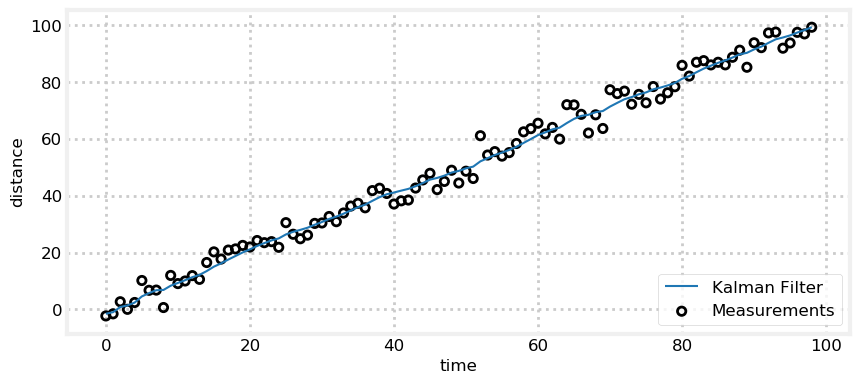

In [51]:
dt = 1.
R = 3.
kf = KalmanFilter(dim_x=2, dim_z=1, dim_u = 1)
kf.P *= 10
kf.R *= R
kf.Q = Q_discrete_white_noise(2, dt, 0.1)
kf.F = np.array([[1., 0], [0., 0.]])
kf.B = np.array([[dt], [ 1.]])
kf.H = np.array([[1., 0]])
print(kf.P)

zs = [i + randn()*R for i in range(1, 100)]
xs = []
cmd_velocity = 1.
for z in zs:
    kf.predict(u=cmd_velocity)
    kf.update(z)
    xs.append(kf.x[0])

plt.plot(xs, label='Kalman Filter')
plot_measurements(zs)
plt.xlabel('time')
plt.legend(loc=4)
plt.ylabel('distance');

## Sensor Fusion

Early in the g-h filter chapter we discussed designing a filter for two scales, one accurate and one  inaccurate. We determined that we should always include the information from the inaccurate filter - we should never discard any information. So consider a situation where we have two sensors measuring the system. How shall we incorporate that into our Kalman filter? 

Suppose we have a train or cart on a railway. It has a sensor attached to the wheels counting revolutions, which can be converted to a distance along the track. Then, suppose we have a GPS-like sensor which I'll call a 'position sensor' mounted to the train which reports position. I'll explain why I don't just use a GPS in the next section. Thus, we have two measurements, both reporting position along the track. Suppose further that the accuracy of the wheel sensor is 1m, and the accuracy of the position sensor is 10m. How do we combine these two measurements into one filter? This may seem quite contrived, but aircraft use sensor fusion to fuse the measurements from sensors such as a GPS, INS, Doppler radar, VOR, the airspeed indicator, and more.

Kalman filters for inertial systems are very difficult, but fusing data from two or more sensors providing measurements of the same state variable (such as position) is quite easy. The relevant matrix is the measurement matrix $\mathbf H$. Recall that this matrix tells us how to convert from the Kalman filter's state $\mathbf x$ to a measurement $\mathbf z$. Suppose that we decide that our Kalman filter state should contain the position and velocity of the train, so that

$$ \mathbf x = \begin{bmatrix}x \\ \dot x\end{bmatrix}$$

We have two measurements for position, so we will define the measurement vector to be a vector of the measurements from the wheel and the position sensor.

$$ \mathbf z = \begin{bmatrix}z_{wheel} \\ z_{ps}\end{bmatrix}$$

So we have to design the matrix $\mathbf H$ to convert $\mathbf x$ to $\mathbf z$ . They are both positions, so the conversion is nothing more than multiplying by one:

$$ \begin{bmatrix}z_{wheel} \\ z_{ps}\end{bmatrix} = \begin{bmatrix}1 &0 \\ 1& 0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}$$

To make it clearer, suppose that the wheel reports not position but the number of rotations of the wheels, where 1 revolution yields 2 meters of travel. In that case we would write

$$ \begin{bmatrix}z_{rot} \\ z_{ps}\end{bmatrix} = \begin{bmatrix}0.5 &0 \\ 1& 0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}$$

Now we have to design the measurement noise matrix $\mathbf R$. Suppose that the measurement variance for the position is twice the variance of the wheel, and the standard deviation of the wheel is 1.5 meters. That gives us

$$
\begin{aligned}
\sigma_{wheel} &=  1.5\\
\sigma^2_{wheel} &= 2.25 \\ 
\sigma_{ps} &= 1.5*2 = 3 \\
\sigma^2_{ps} &= 9.
\end{aligned}
$$

That is pretty much our Kalman filter design. We need to design for $\mathbf Q$, but that is invariant to whether we are doing sensor fusion or not, so I will just choose some arbitrary value.

So let's run a simulation of this design. I will assume a velocity of 10 m/s with an update rate of 0.1 seconds.

fusion std: 1.647


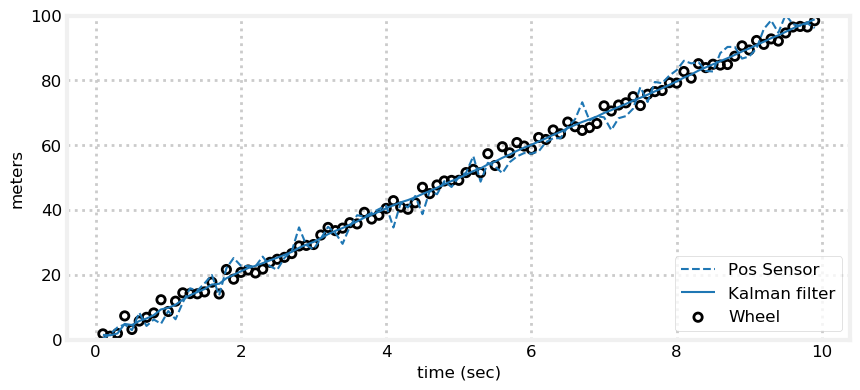

In [52]:
from numpy import array, asarray
import numpy.random as random

def fusion_test(wheel_sigma, ps_sigma, do_plot=True):
    dt = 0.1
    kf = KalmanFilter(dim_x=2, dim_z=2)

    kf.F = array([[1., dt], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.Q *= array([[(dt**3)/3, (dt**2)/2],
                   [(dt**2)/2,  dt      ]]) * 0.02
    kf.P *= 100
    kf.R[0, 0] = wheel_sigma**2
    kf.R[1, 1] = ps_sigma**2 
    s = Saver(kf)

    random.seed(1123)
    for i in range(1, 100):
        m0 = i + randn()*wheel_sigma
        m1 = i + randn()*ps_sigma
        kf.predict()
        kf.update(array([[m0], [m1]]))
        s.save()
    s.to_array()
    print('fusion std: {:.3f}'.format(np.std(s.y[:, 0])))
    if do_plot:
        ts = np.arange(0.1, 10, .1)
        plot_measurements(ts, s.z[:, 0], label='Wheel')
        plt.plot(ts, s.z[:, 1], ls='--', label='Pos Sensor')
        plot_filter(ts, s.x[:, 0], label='Kalman filter')
        plt.legend(loc=4)
        plt.ylim(0, 100)
        set_labels(x='time (sec)', y='meters')

fusion_test(1.5, 3.0)

We can see the result of the Kalman filter in blue.

It may be somewhat difficult to understand the previous example at an intuitive level. Let's look at a different problem. Suppose we are tracking an object in 2D space, and have two radar systems at different positions. Each radar system gives us a range and bearing to the target. How do the readings from each data affect the results?

This is a nonlinear problem because we need to use trigonometry  to compute coordinates from a range and bearing, and we have not yet learned how to solve nonlinear problems with Kalman filters. So for this problem ignore the code that I use and just concentrate on the charts that the code outputs. We will revisit this problem in subsequent chapters and learn how to write this code.

I will position the target at (100, 100). The first radar will be at (50, 50), and the second radar at (150, 50). This will cause the first radar to measure a bearing of 45 degrees, and the second will report 135 degrees.

I will create the Kalman filter first, and then plot its initial covariance matrix. I am using an **unscented Kalman filter**, which is covered in a later chapter.

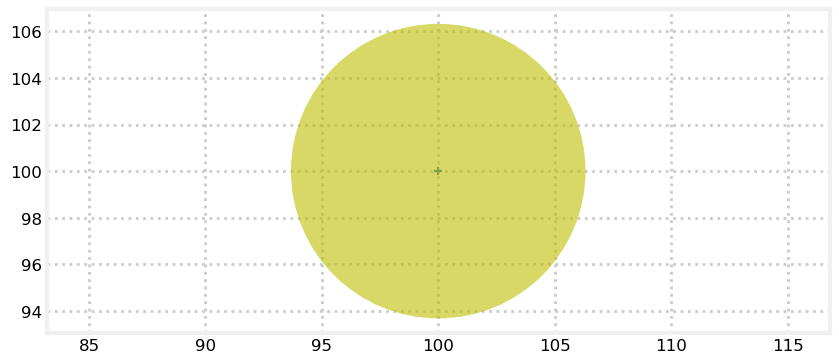

In [53]:
from kf_book.kf_design_internal import sensor_fusion_kf

kf = sensor_fusion_kf()
x0, p0 = kf.x.copy(), kf.P.copy()
plot_covariance_ellipse(x0, p0, fc='y', ec=None, alpha=0.6)

We are equally uncertain about the position in x and y, so the covariance is circular.

Now we will update the Kalman filter with a reading from the first radar. I will set the standard deviation of the bearing error at 0.5$^\circ$, and the standard deviation of the distance error at 3.

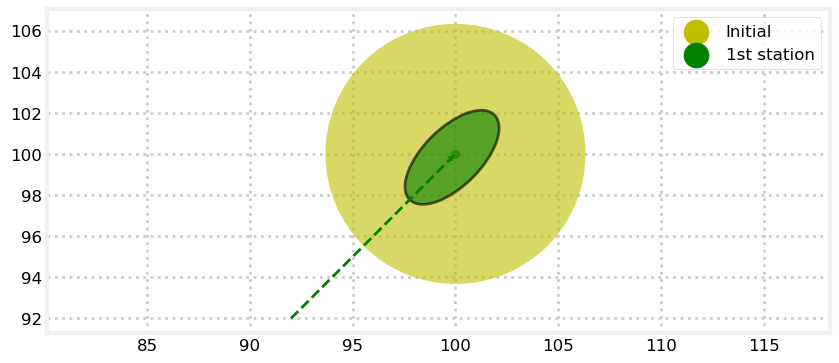

In [54]:
from math import radians
from kf_book.kf_design_internal import sensor_fusion_kf, set_radar_pos

# set the error of the radar's bearing and distance
kf.R[0, 0] = radians (.5)**2
kf.R[1, 1] = 3.**2

# compute position and covariance from first radar station
set_radar_pos((50, 50))
dist = (50**2 + 50**2) ** 0.5
kf.predict()
kf.update([radians(45), dist])

# plot the results
x1, p1 = kf.x.copy(), kf.P.copy()

plot_covariance_ellipse(x0, p0, fc='y', ec=None, alpha=0.6)
plot_covariance_ellipse(x1, p1, fc='g', ec='k', alpha=0.6)

plt.scatter([100], [100], c='y', label='Initial')
plt.scatter([100], [100], c='g', label='1st station')
plt.legend(scatterpoints=1, markerscale=3)
plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--');

We can see the effect of the errors on the geometry of the problem. The radar station is to the lower left of the target. The bearing measurement is extremely accurate at $\sigma=0.5^\circ$, but the distance error is inaccurate at $\sigma=3$. I've shown the radar reading with the dotted green line. We can easily see the effect of the accurate bearing and inaccurate distance in the shape of the covariance ellipse. 

Now we can incorporate the second radar station's measurement. The second radar is at (150,50), which is below and to the right of the target. Before you go on, think about how you think the covariance will change when we incorporate this new reading.

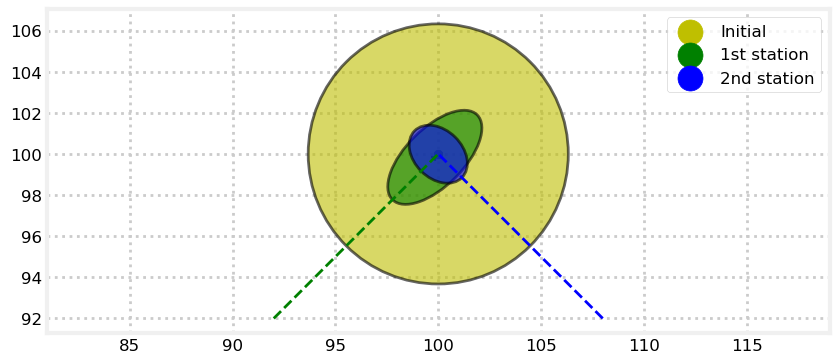

In [55]:
# compute position and covariance from second radar station
set_radar_pos((150, 50))
kf.predict()
kf.update([radians(135), dist])

plot_covariance_ellipse(x0, p0, fc='y', ec='k', alpha=0.6)
plot_covariance_ellipse(x1, p1, fc='g', ec='k', alpha=0.6)
plot_covariance_ellipse(kf.x, kf.P, fc='b', ec='k', alpha=0.6)

plt.scatter([100], [100], c='y', label='Initial')
plt.scatter([100], [100], c='g', label='1st station')
plt.scatter([100], [100], c='b', label='2nd station')
plt.legend(scatterpoints=1, markerscale=3)
plt.plot([92, 100], [92, 100], c='g', lw=2, ls='--')
plt.plot([108, 100], [92, 100], c='b', lw=2, ls='--');

We can see how the second radar measurement altered the covariance. The angle to the target is orthogonal to the first radar station, so the effects of the error in the bearing and range are swapped. So the angle of the covariance matrix switches to match the direction to the second station. It is important to note that the direction did not merely change; the size of the covariance matrix became much smaller as well.

The covariance will always incorporate all of the information available, including the effects of the geometry of the problem. This formulation makes it particularly easy to see what is happening, but the same thing occurs if one sensor gives you position and a second sensor gives you velocity, or if two sensors provide measurements of position.

One final thing before we move on: sensor fusion is a vast topic, and my coverage is simplistic to the point of being misleading. For example, GPS uses iterated least squares to determine the position from a set of pseudorange readings from the satellites without using a Kalman filter. I cover this topic in the supporting notebook [**Iterative Least Squares for Sensor Fusion**](http://nbviewer.ipython.org/urls/raw.github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/master/Supporting_Notebooks/Iterative-Least-Squares-for-Sensor-Fusion.ipynb)

That is the usual but not exclusive way this computation is done in GPS receivers. If you are a hobbyist my coverage may get you started. A commercial grade filter requires very careful design of the fusion process. That is the topic of several books, and you will have to further your education by finding one that covers your domain. 

### Exercise: Can you Filter GPS outputs?

In the section above I have you apply a Kalman filter to a 'GPS-like' sensor. Can you apply a Kalman filter to the output of a commercial Kalman filter? In other words, will the output of your filter be better than, worse than, or equal to the GPS's output?

#### Solution

Commercial GPS's have a Kalman filter built into them, and their output is the filtered estimate created by that filter. So, suppose you have a steady stream of output from the GPS consisting of a position and position error. Can you not pass those two pieces of data into your own filter?

Well, what are the characteristics of that data stream, and more importantly, what are the fundamental requirements of the input to the Kalman filter?

Inputs to the Kalman filter must be *Gaussian* and *time independent*. This is because we imposed the requirement of the Markov property: the current state is dependent only on the previous state and current inputs. This makes the recursive form of the filter possible. The output of the GPS is *time dependent* because the filter bases its current estimate on the recursive estimates of all previous measurements. Hence, the signal is not white, it is not time independent, and if you pass that data into a Kalman filter you have violated the mathematical requirements of the filter. So, the answer is no, you cannot get better estimates by running a KF on the output of a commercial GPS. 

Another way to think of it is that Kalman filters are optimal in a least squares sense. There is no way to take an optimal solution, pass it through a filter, any filter, and get a 'more optimal' answer because it is a logical impossibility. At best the signal will be unchanged, in which case it will still be optimal, or it will be changed, and hence no longer optimal.

This is a difficult problem that hobbyists face when trying to integrate GPS, IMU's and other off the shelf sensors. 

Let's look at the effect. A commercial GPS reports position, and an estimated error range. The estimated error just comes from the Kalman filter's $\mathbf P$ matrix. So let's filter some noisy data, take the filtered output as the new noisy input to the filter, and see what the result is. In other words, $\mathbf x$ will supply the  $\mathbf z$ input, and  $\mathbf P$ will supply the measurement covariance $\mathbf R$. To exaggerate the effects somewhat to make them more obvious I will plot the effects of doing this one, and then a second time. The second iteration doesn't make any 'sense' (no one would try that), it just helps me illustrate a point. First, the code and plots.

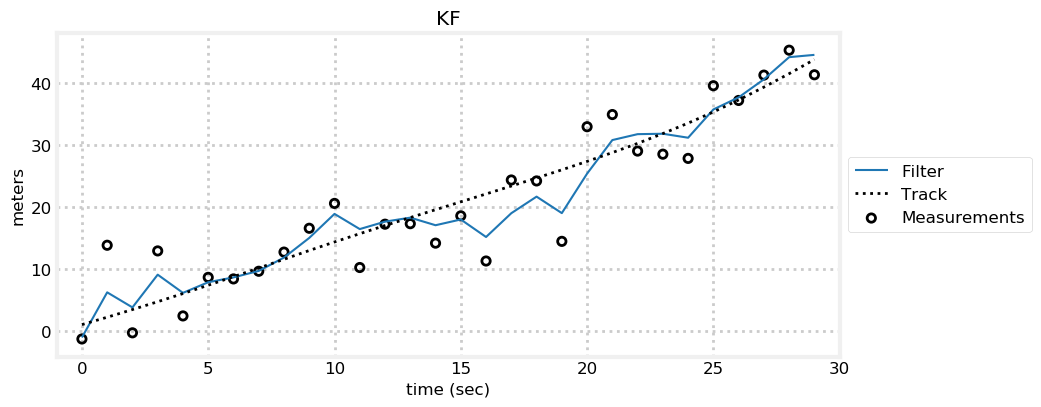

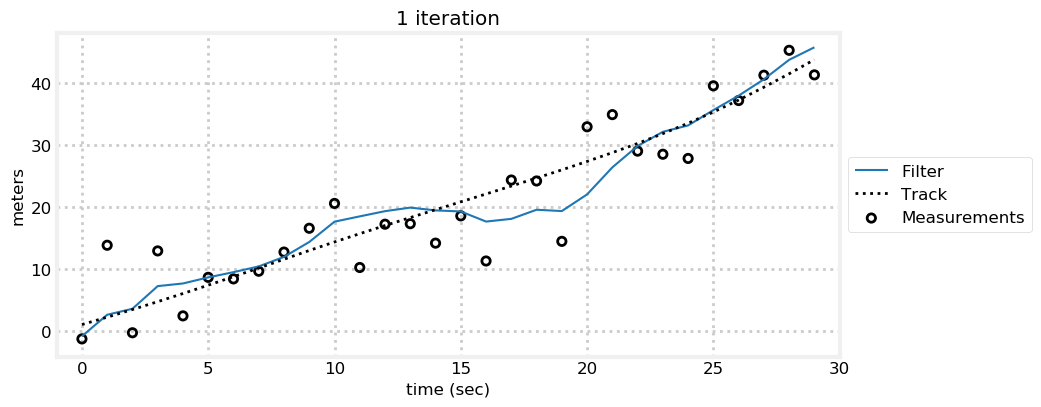

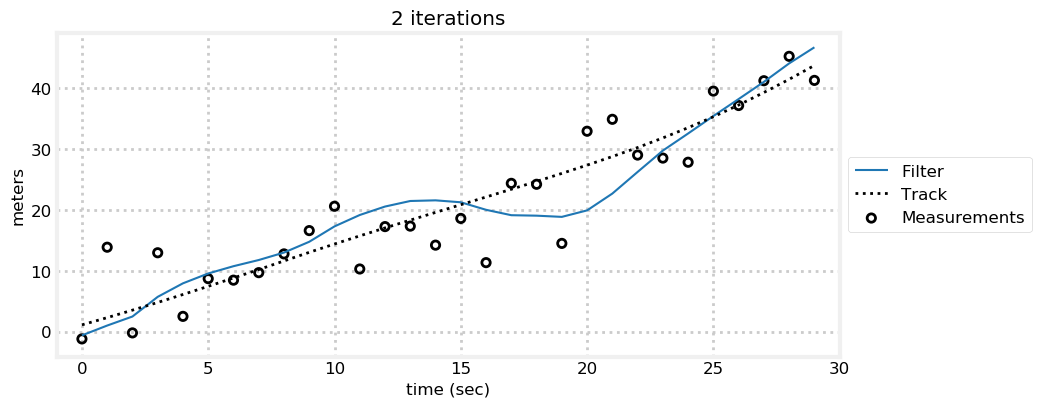

(5.0, 0.02)

In [56]:
np.random.seed(124)
R = 5.
xs, zs = simulate_acc_system(R=R, Q=Q, count=30)

kf0 = SecondOrderKF(R, Q, dt=1)
kf1 = SecondOrderKF(R, Q, dt=1)
kf2 = SecondOrderKF(R, Q, dt=1)

# Filter measurements
fxs0, ps0, _, _ = kf0.batch_filter(zs)

# filter twice more, using the state as the input
fxs1, ps1, _, _ = kf1.batch_filter(fxs0[:, 0])
fxs2, _, _, _ = kf2.batch_filter(fxs1[:, 0])

plot_kf_output(xs, fxs0, zs, 'KF', False)
plot_kf_output(xs, fxs1, zs, '1 iteration', False)
plot_kf_output(xs, fxs2, zs, '2 iterations', False)
R,Q

We see that the filtered output of the reprocessed signal is smoother, but it also diverges from the track. What is happening? Recall that the Kalman filter requires that the signal not be time correlated. However the output of the Kalman filter *is* time correlated because it incorporates all previous measurements into its estimate for this time period. So look at the last graph, for 2 iterations. The measurements start with several peaks that are larger than the track. This is 'remembered' (that is vague terminology, but I am trying to avoid the math) by the filter, and it has started to compute that the object is above the track. Later, at around 13 seconds we have a period where the measurements all happen to be below the track. This also gets incorporated into the memory of the filter, and the iterated output diverges far below the track. 

Now let's look at this in a different way. The iterated output is *not* using $\mathbf z$ as the measurement, but the output of the previous Kalman filter estimate. So I will plot the output of the filter against the previous filter's output.

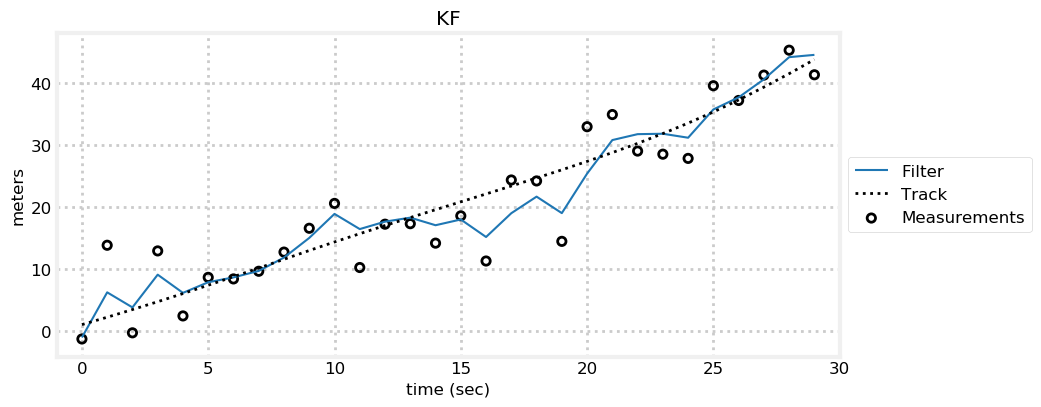

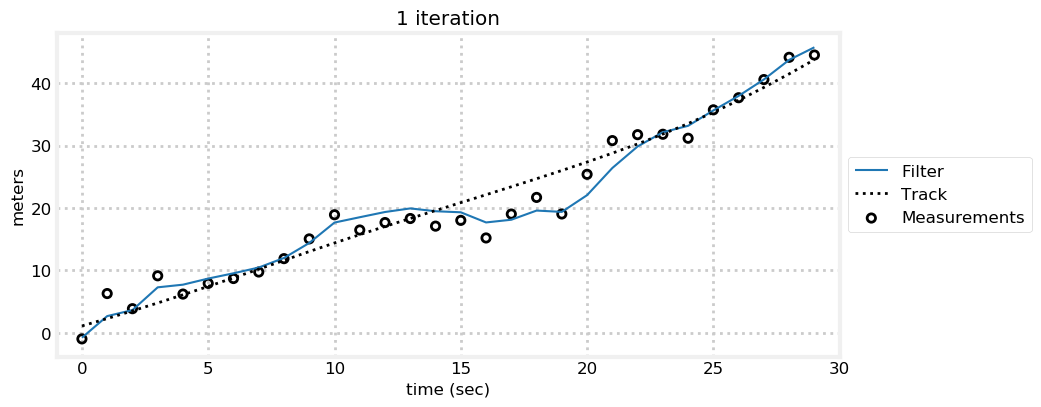

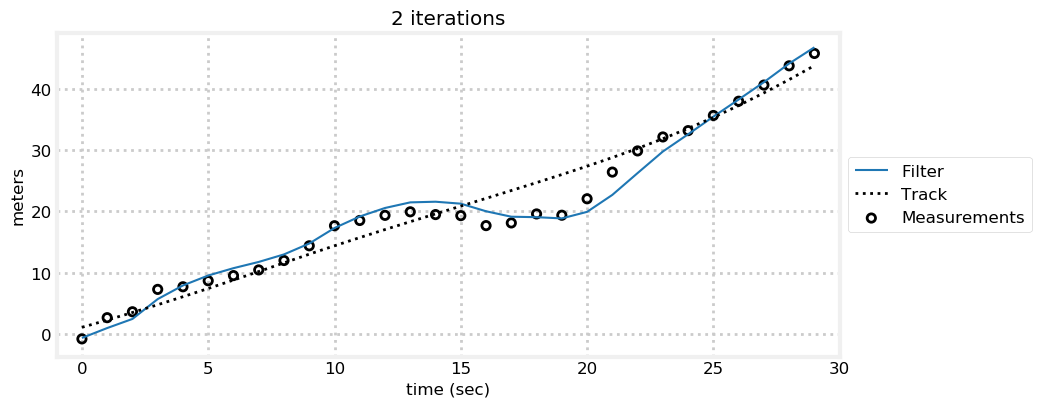

In [57]:
plot_kf_output(xs, fxs0, zs, title='KF', aspect_equal=False)
plot_kf_output(xs, fxs1, fxs0[:, 0], '1 iteration', False)
plot_kf_output(xs, fxs2, fxs1[:, 0], '2 iterations', False)

I hope the problem with this approach is now apparent. In the bottom graph we can see that the KF is tracking the imperfect estimates of the previous filter, and incorporating delay into the signal as well due to the memory of the previous measurements being incorporated into the signal.

### Exercise: Prove that the position sensor improves the filter

Devise a way to prove that fusing the position sensor and wheel measurements yields a better result than using the wheel alone.

#### Solution 1

Force the Kalman filter to disregard the position sensor measurement by setting the measurement noise for the position sensor to a near infinite value. Re-run the filter and observe the standard deviation of the residual.

In [58]:
fusion_test(1.5, 3.0, do_plot=False)
fusion_test(1.5, 1.e40, do_plot=False)

fusion std: 1.647
fusion std: 1.647


Here we can see the error in the filter where the position sensor measurement is almost entirely ignored is greater than that where it is used.

#### Solution 2

This is more work, but we can write a Kalman filter that only takes one measurement.

std: 0.523


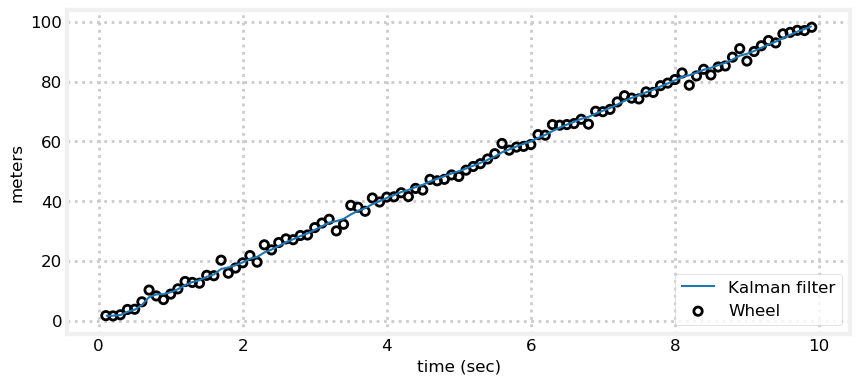

In [59]:
dt = 0.1
wheel_sigma = 1.5
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.F = array([[1., dt], [0., 1.]])
kf.H = array([[1., 0.]])
kf.x = array([[0.], [1.]])
kf.Q *= 0.01
kf.P *= 100
kf.R[0, 0] = wheel_sigma**2

random.seed(1123)
nom = range(1, 100)
zs = np.array([i + randn()*wheel_sigma for i in nom])
xs, _, _, _ = kf.batch_filter(zs)
ts = np.arange(0.1, 10, .1)

res = nom - xs[:, 0, 0]
print('std: {:.3f}'.format(np.std(res)))

plot_filter(ts, xs[:, 0], label='Kalman filter')
plot_measurements(ts, zs, label='Wheel')
set_labels(x='time (sec)', y='meters')
plt.legend(loc=4);

On this run I got a standard deviation of 0.523 vs the value of 0.391 for the fused measurements. 

## Nonstationary Processes

So far we have assumed that the various matrices in the Kalman filter are *stationary* - nonchanging over time. For example, in the robot tracking section we assumed that $\Delta t = 1.0$ seconds, and designed the state transition matrix to be

$$
\mathbf F = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix} = \begin{bmatrix}1& 1& 0& 0\\0& 1& 0& 0\\0& 0& 1& 1\\ 0& 0& 0& 1\end{bmatrix}$$

But what if our data rate changes in some unpredictable manner? Or what if we have two sensors, each running at a different rate? What if the error of the measurement changes? 

Handling this is easy; you just alter the Kalman filter matrices to reflect the current situation. Let's go back to our dog tracking problem and assume that the data input is somewhat sporadic. For this problem we designed


$$\begin{aligned}
\mathbf{\bar x} &= {\begin{bmatrix}x\\\dot x\end{bmatrix}}^- \\
\mathbf F &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix} 
\end{aligned}$$

and set the Kalman filter variable `F` during initialization like so:

```python
dt = 0.1
kf.F = np.array([[1, dt],
                 [0, 1]])
```

How would we handle $\Delta t$ changing for each measurement? It's easy - just modify the relevant matrices. In this case `F` is variant, so we will need to update this inside the update/predict loop.  `Q` is also dependent on time, so it must be assigned during each loop as well. Here is an example of how we might code this:

In [60]:
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = array([0., 1.])
kf.H = array([[1, 0]])
kf.P = np.eye(2) * 50
kf.R = 1.
Q = 0.02

# measurement tuple: (value, time)
zs = [(1., 1.),  (2., 1.1), (3., 0.9), (4.1, 1.23), (5.01, 0.97)]
for z, dt in zs:
    kf.F = array([[1, dt],
                  [0, 1]])
    kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    kf.predict()
    kf.update(z)
    print(kf.x)

[1. 1.]
[2.   0.92]
[2.96 1.  ]
[4.12 0.97]
[5.03 0.96]


### Sensor fusion: Different Data Rates

It is rare that two different sensor classes output data at the same rate. Assume that the position sensor produces an update at 3 Hz, and the wheel updates at 7 Hz. Further assume that the timing is not precise - there is a bit of jitter such that a measurement can occur a bit before or after the predicted time. Let me further complicate the situation by having the wheel provide velocity estimates rather than position estimates.

We can do this by waiting for a data packet from either sensor. When we get it, we determine the amount of time that has passed since the last update. We then need to modify the affected matrices. Both $\mathbf F$ and $\mathbf Q$ contain a time term $\Delta t$ so we will need to adjust these on every innovation. 

The measurement changes each time, so we will have to modify $\mathbf H$ and $\mathbf R$. The position sensor alters the position element of $\mathbf x$, so we assign:

$$\begin{aligned}
\mathbf H &= \begin{bmatrix}1 &0\end{bmatrix} \\
\mathbf R &= \sigma_{ps}^2
\end{aligned}$$

The wheel sensor alters the velocity element of $\mathbf x$, so we assign:

$$\begin{aligned}
\mathbf H &= \begin{bmatrix}0 &1\end{bmatrix} \\
\mathbf R &= \sigma_{wheel}^2
\end{aligned}$$

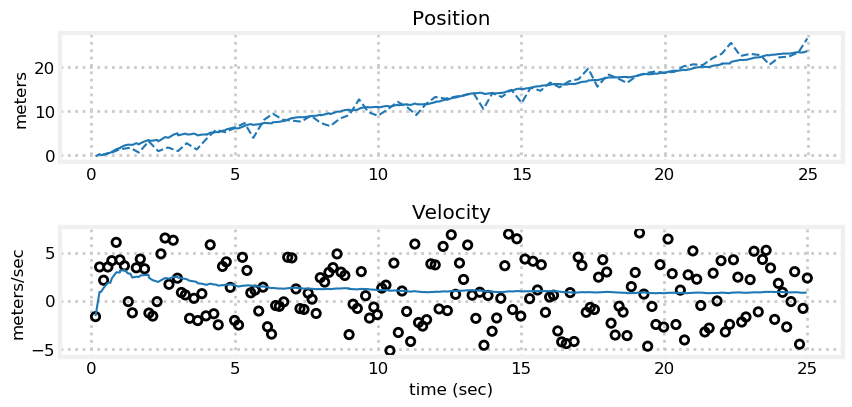

In [61]:
def gen_sensor_data(t, ps_std, wheel_std):
    # generate simulated sensor data
    pos_data, vel_data = [], []
    dt = 0.
    for i in range(t*3):
        dt += 1/3.
        t_i = dt + randn() * .01 # time jitter
        pos_data.append([t_i, t_i + randn()*ps_std])

    dt = 0.    
    for i in range(t*7):
        dt += 1/7.
        t_i = dt + randn() * .006 # time jitter
        vel_data.append([t_i, 1. + randn()*wheel_std])
    return pos_data, vel_data


def plot_fusion(xs, ts, zs_ps, zs_wheel):
    xs = np.array(xs)
    plt.subplot(211)
    plt.plot(zs_ps[:, 0], zs_ps[:, 1], ls='--', label='Pos Sensor')
    plot_filter(xs=ts, ys=xs[:, 0], label='Kalman filter')
    set_labels(title='Position', y='meters',)

    plt.subplot(212)
    plot_measurements(zs_wheel[:, 0], zs_wheel[:, 1],  label='Wheel')
    plot_filter(xs=ts, ys=xs[:, 1], label='Kalman filter')
    set_labels('Velocity', 'time (sec)', 'meters/sec')
    

def fusion_test(pos_data, vel_data, wheel_std, ps_std):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.F = array([[1., 1.], [0., 1.]])
    kf.H = array([[1., 0.], [1., 0.]])
    kf.x = array([[0.], [1.]])
    kf.P *= 100

    xs, ts = [],  []
    
    # copy data for plotting
    zs_wheel = np.array(vel_data)
    zs_ps = np.array(pos_data)
                     
    last_t = 0
    while len(pos_data) > 0 and len(vel_data) > 0:
        if pos_data[0][0] < vel_data[0][0]:
            t, z = pos_data.pop(0)
            dt = t - last_t
            last_t = t
            
            kf.H = np.array([[1., 0.]])
            kf.R[0,0] = ps_std**2
        else:
            t, z = vel_data.pop(0)
            dt = t - last_t
            last_t = t
            
            kf.H = np.array([[0., 1.]])
            kf.R[0,0] = wheel_std**2

        kf.F[0,1] = dt
        kf.Q = Q_discrete_white_noise(2, dt=dt, var=.02)
        kf.predict()
        kf.update(np.array([z]))

        xs.append(kf.x.T[0])
        ts.append(t)
    plot_fusion(xs, ts, zs_ps, zs_wheel)

random.seed(1123)
pos_data, vel_data = gen_sensor_data(25, 1.5, 3.0)
fusion_test(pos_data, vel_data, 1.5, 3.0);

## Tracking a Ball

Now let's turn our attention to a situation where the physics of the object that we are tracking is constrained. A ball thrown in a vacuum must obey Newtonian laws. In a constant gravitational field it will travel in a parabola. I will assume you are familiar with the derivation of the formula:

$$
\begin{aligned}
y &= \frac{g}{2}t^2 + v_{y0} t + y_0 \\
x &= v_{x0} t + x_0
\end{aligned}
$$

where $g$ is the gravitational constant, $t$ is time, $v_{x0}$ and $v_{y0}$ are the initial velocities in the x and y plane. If the ball is thrown with an initial velocity of $v$ at angle $\theta$ above the horizon, we can compute $v_{x0}$ and $v_{y0}$ as

$$
\begin{aligned}
v_{x0} = v \cos{\theta} \\
v_{y0} = v \sin{\theta}
\end{aligned}
$$

Because we don't have real data we will start by writing a simulator for a ball. As always, we add a noise term independent of time so we can simulate noisy sensors.

In [62]:
from math import radians, sin, cos
import math

def rk4(y, x, dx, f):
    """computes 4th order Runge-Kutta for dy/dx.
    y is the initial value for y
    x is the initial value for x
    dx is the difference in x (e.g. the time step)
    f is a callable function (y, x) that you supply to 
      compute dy/dx for the specified values.
    """
    
    k1 = dx * f(y, x)
    k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
    k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
    k4 = dx * f(y + k3, x + dx)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

def fx(x,t):
    return fx.vel
    
def fy(y,t):
    return fy.vel - 9.8*t


class BallTrajectory2D(object):
    def __init__(self, x0, y0, velocity, 
                 theta_deg=0., 
                 g=9.8, 
                 noise=[0.0, 0.0]):
        self.x = x0
        self.y = y0
        self.t = 0        
        theta = math.radians(theta_deg)
        fx.vel = math.cos(theta) * velocity
        fy.vel = math.sin(theta) * velocity        
        self.g = g
        self.noise = noise
        
        
    def step(self, dt):
        self.x = rk4(self.x, self.t, dt, fx)
        self.y = rk4(self.y, self.t, dt, fy)
        self.t += dt 
        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])

So to create a trajectory starting at (0, 15) with a velocity of 100 m/s and an angle of 60° we would write:

```python
traj = BallTrajectory2D(x0=0, y0=15, velocity=100, theta_deg=60)
```
    
and then call `traj.step(t)` for each time step. Let's test this 

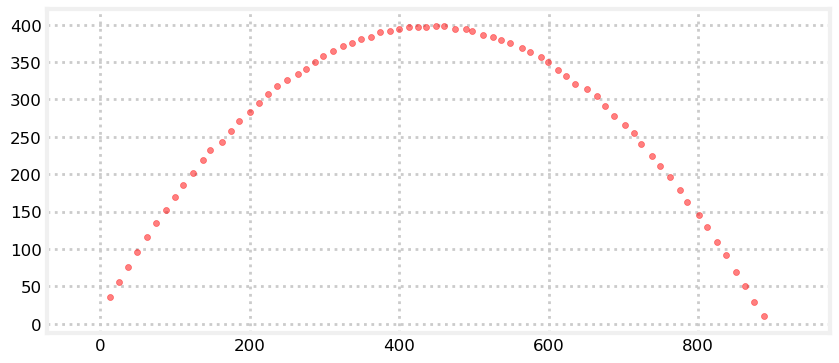

In [63]:
def test_ball_vacuum(noise):
    y = 15
    x = 0
    ball = BallTrajectory2D(x0=x, y0=y, 
                            theta_deg=60., velocity=100., 
                            noise=noise)
    t = 0
    dt = 0.25
    while y >= 0:
        x, y = ball.step(dt)
        t += dt
        if y >= 0:
            plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)
         
    plt.axis('equal');
    
#test_ball_vacuum([0, 0]) # plot ideal ball position
test_ball_vacuum([1, 1]) # plot with noise 

This looks reasonable, so let's continue (exercise for the reader: validate this simulation more robustly).

### Choose the State Variables

We might think to use the same state variables as used for tracking the dog. However, this will not work. Recall that the Kalman filter state transition must be written as $\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$, which means we must calculate the current state from the previous state. Our assumption is that the ball is traveling in a vacuum, so the velocity in x is a constant, and the acceleration in y is solely due to the gravitational constant $g$. We can discretize the Newtonian equations using the well known Euler method in terms of $\Delta t$ are:

$$\begin{aligned}
x_t &=  x_{t-1} + v_{x(t-1)} {\Delta t} \\
v_{xt} &= v_{x(t-1)} \\
y_t &= y_{t-1} + v_{y(t-1)} {\Delta t} \\
v_{yt} &= -g {\Delta t} + v_{y(t-1)} \\
\end{aligned}
$$

> **sidebar**: *Euler's method integrates a differential equation stepwise by assuming the slope (derivative) is constant at time $t$. In this case the derivative of the position is velocity. At each time step $\Delta t$ we assume a constant velocity, compute the new position, and then update the velocity for the next time step. There are more accurate methods, such as Runge-Kutta available to us, but because we are updating the state with a measurement in each step Euler's method is very accurate. If you need to use Runge-Kutta you will have to write your own `predict()` function which computes the state transition for $\mathbf x$, and then uses the normal Kalman filter equation $\mathbf{\bar P}=\mathbf{FPF}^\mathsf T + \mathbf Q$ to update the covariance matrix.*

This implies that we need to incorporate acceleration for $y$ into the Kalman filter, but not for $x$. This suggests the following state variable.

$$
\mathbf x = 
\begin{bmatrix}
x & \dot x & y & \dot y & \ddot{y}
\end{bmatrix}^\mathsf T
$$

However, the acceleration is due to gravity, which is a constant. Instead of asking the Kalman filter to track a constant we can treat gravity as what it really is - a control input. In other words, gravity is a force that alters the behavior of the system in a known way, and it is applied throughout the flight of the ball. 

The equation for the state prediction is $\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$. $\mathbf{Fx}$ is the familiar state transition function which we will use to model the position and velocity of the ball. The vector $\mathbf{u}$ lets you specify a control input into the filter. For a car the control input will be things such as the amount the accelerator and brake are pressed, the position of the steering wheel, and so on. For our ball the control input will be gravity. The matrix $\mathbf{B}$ models how the control inputs affect the behavior of the system. Again, for a car $\mathbf{B}$ will convert the inputs of the brake and accelerator into changes of velocity, and the input of the steering wheel into a different position and heading. For our ball tracking problem it will compute the velocity change due to gravity. We will go into the details of that soon. For now, we design the state variable to be

$$
\mathbf x = 
\begin{bmatrix}x & \dot x & y & \dot y 
\end{bmatrix}^\mathsf T
$$

### Design State Transition Function

Our next step is to design the state transition function. Recall that the state transition function is implemented as a matrix $\mathbf F$ that we multiply with the previous state of our system to get the next state, or prior $\bar{\mathbf x} = \mathbf{Fx}$.

I will not belabor this as it is very similar to the 1-D case we did in the previous chapter. Our state equations for position and velocity would be:

$$
\begin{aligned}
\bar x &= (1*x) + (\Delta t * v_x) + (0*y) + (0 * v_y) \\
\bar v_x &= (0*x) +  (1*v_x) + (0*y) + (0 * v_y) \\
\bar y &= (0*x) + (0* v_x)         + (1*y) + (\Delta t * v_y)   \\
\bar v_y &= (0*x) +  (0*v_x) + (0*y) + (1*v_y) 
\end{aligned}
$$

Note that none of the terms include $g$, the gravitational constant. As I explained in the previous function we will account for gravity using the control input of the Kalman filter.
In matrix form we write this as:

$$
\mathbf F = \begin{bmatrix}
1 & \Delta t & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

### Design the Control Input Function

We will use the control input to account for the force of gravity. The term $\mathbf{Bu}$ is added to $\mathbf{\bar x}$ to account for how much $\mathbf{\bar x}$ changes due to gravity. We can say that  $\mathbf{Bu}$ contains $\begin{bmatrix}\Delta x_g & \Delta \dot{x_g} & \Delta y_g & \Delta \dot{y_g}\end{bmatrix}^\mathsf T$.

If we look at the discretized equations we see that gravity only affects the velocity for $y$.

$$\begin{aligned}
x_t &=  x_{t-1} + v_{x(t-1)} {\Delta t} \\
v_{xt} &= vx_{t-1}
\\
y_t &= y_{t-1} + v_{y(t-1)} {\Delta t}\\
v_{yt} &= -g {\Delta t} + v_{y(t-1)} \\
\end{aligned}
$$

Therefore we want the product $\mathbf{Bu}$ to equal $\begin{bmatrix}0 & 0 & 0 & -g \Delta t \end{bmatrix}^\mathsf T$. In some sense it is arbitrary how we define $\mathbf{B}$ and $\mathbf{u}$ so long as multiplying them together yields this result. For example, we could define $\mathbf{B}=1$ and $\mathbf{u} = \begin{bmatrix}0 & 0 & 0 & -g \Delta t \end{bmatrix}^\mathsf T$. But this doesn't really fit with our definitions for $\mathbf{B}$ and $\mathbf{u}$, where $\mathbf{u}$ is the control input, and $\mathbf{B}$ is the control function. The control input is $-g$ for the velocity of y. So this is one possible definition.

$$\mathbf{B} = \begin{bmatrix}0&0&0&0 \\ 0&0&0&0 \\0&0&0&0 \\0&0&0&\Delta t\end{bmatrix}, \mathbf{u} = \begin{bmatrix}0\\0\\0\\-g\end{bmatrix}$$

To me this seems a bit excessive; I would suggest we might want $\mathbf{u}$ to contain the control input for the two dimensions $x$ and $y$, which suggests

$$\mathbf{B} = \begin{bmatrix}0&0 \\ 0&0 \\0&0 \\0&\Delta t\end{bmatrix}, \mathbf{u} = \begin{bmatrix}0\\-g\end{bmatrix}$$.

You might prefer to only provide control inputs that actually exist, and there is no control input for $x$, so we arrive at

$$\mathbf{B} = \begin{bmatrix}0 \\ 0 \\0\\ \Delta t\end{bmatrix}, \mathbf{u} = \begin{bmatrix}-g\end{bmatrix}$$.

I've seen people use 
$$\mathbf{B} = \begin{bmatrix}0&0&0&0 \\ 0&0&0&0 \\0&0&0&0 \\0&0&0&1\end{bmatrix}, \mathbf{u} = \begin{bmatrix}0\\0\\0\\-g \Delta t\end{bmatrix}$$

While this does produce the correct result, I am resistant to putting time into $\mathbf{u}$  as time is not a control input, it is what we use to convert the control input into a change in state, which is the job of $\mathbf{B}$.

### Design the Measurement Function

The measurement function defines how we go from the state variables to the measurements using the equation $\mathbf z = \mathbf{Hx}$. We will assume that we have a sensor that provides us with the position of the ball in (x,y), but cannot measure velocities or accelerations. Therefore our function must be:

$$
\begin{bmatrix}z_x \\ z_y \end{bmatrix}= 
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix} 
\begin{bmatrix}
x \\
\dot x \\
y \\
\dot y \end{bmatrix}$$

where

$$\mathbf H = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0
\end{bmatrix}$$

### Design the Measurement Noise Matrix

As with the robot, we will assume that the error is independent in $x$ and $y$. In this case we will start by assuming that the measurement errors in x and y are 0.5 meters squared. Hence,

$$\mathbf R = \begin{bmatrix}0.5&0\\0&0.5\end{bmatrix}$$

### Design the Process Noise Matrix

We are assuming a ball moving in a vacuum, so there should be no process noise. We have 4 state variables, so we need a $4{\times}4$ covariance matrix:

$$\mathbf Q = \begin{bmatrix}0&0&0&0\\0&0&0&0\\0&0&0&0\\0&0&0&0\end{bmatrix}$$

### Design the Initial Conditions

We already performed this step when we tested the state transition function. Recall that we computed the initial velocity for $x$ and $y$ using trigonometry, and set the value of $\mathbf x$ with:

```python
omega = radians(omega)
vx = cos(omega) * v0
vy = sin(omega) * v0

f1.x = np.array([[x, vx, y, vy]]).T
```
    
With all the steps done we are ready to implement our filter and test it. First, the implementation:

In [64]:
from math import sin, cos, radians

def ball_kf(x, y, omega, v0, dt, r=0.5, q=0.):
    kf = KalmanFilter(dim_x=4, dim_z=2, dim_u=1)

    kf.F = np.array([[1., dt, 0., 0.],   # x   = x0 + dx*dt
                     [0., 1., 0., 0.],   # dx  = dx0
                     [0., 0., 1., dt],   # y   = y0 + dy*dt
                     [0., 0., 0., 1.]])  # dy  = dy0

    kf.H = np.array([[1., 0., 0., 0.],
                     [0., 0., 1., 0.]])
    
    kf.B = np.array([[0., 0., 0., dt]]).T
    kf.R *= r
    kf.Q *= q

    omega = radians(omega)
    vx = cos(omega) * v0
    vy = sin(omega) * v0
    kf.x = np.array([[x, vx, y, vy]]).T
    return kf

Now we will test the filter by generating measurements for the ball using the ball simulation class.

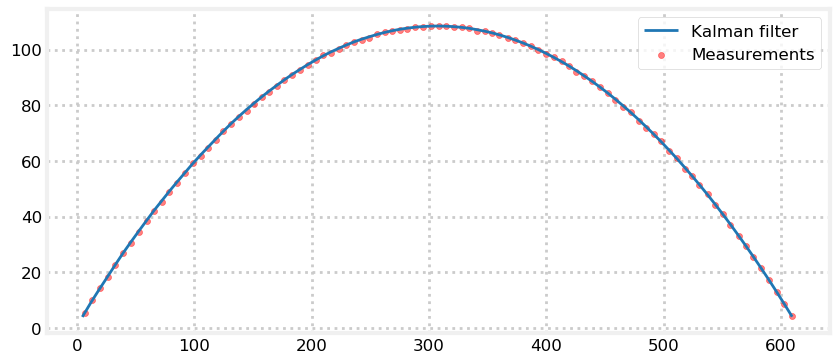

In [65]:
def track_ball_vacuum(dt):
    x, y = 0., 1.
    theta = 35. # launch angle
    v0 = 80.
    g = 9.8 # gravitational constant
    ball = BallTrajectory2D(x0=x, y0=y, theta_deg=theta, velocity=v0, 
                            noise=[.2, .2])
    kf = ball_kf(x, y, theta, v0, dt)

    t = 0
    xs, ys = [], []
    while kf.x[2] > 0:
        t += dt
        x, y = ball.step(dt)
        z = np.array([[x, y]]).T

        kf.update(z)
        xs.append(kf.x[0])
        ys.append(kf.x[2])    
        kf.predict(u=-g)     
        p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)

    p2, = plt.plot(xs, ys, lw=2)
    plt.legend([p2, p1], ['Kalman filter', 'Measurements'],
               scatterpoints=1)
    
track_ball_vacuum(dt=1./10)

We see that the Kalman filter reasonably tracks the ball. However, as already explained, this is a trivial example because we have no process noise. We can predict trajectories in a vacuum with arbitrary precision; using a Kalman filter in this example is a needless complication. A least squares curve fit would give identical results.

## Tracking a Ball in Air

For this problem we assume that we are tracking a ball traveling through the Earth's atmosphere. The path of the ball is influenced by wind, drag, and the rotation of the ball. We will assume that our sensor is a camera; code that we will not implement will perform some type of image processing to detect the position of the ball. This is typically called *blob detection* in computer vision. However, image processing code is not perfect; in any given frame it is possible to either detect no blob or to detect spurious blobs that do not correspond to the ball. Finally, we will not assume that we know the starting position, angle, or rotation of the ball; the tracking code will have to initiate tracking based on the measurements that are provided. The main simplification that we are making here is a 2D world; we assume that the ball is always traveling orthogonal to the plane of the camera's sensor. We have to make that simplification at this point because we have not discussed how we might extract 3D information from a camera, which provides only 2D data. 

### Implementing Air Drag

Our first step is to implement the math for a ball moving through air. There are several treatments available. A robust solution takes into account issues such as ball roughness (which affects drag non-linearly depending on velocity), the Magnus effect (spin causes one side of the ball to have higher velocity relative to the air vs the opposite side, so the coefficient of drag differs on opposite sides), the effect of lift, humidity, air density, and so on. I assume the reader is not interested in the details of ball physics, and so will restrict this treatment to the effect of air drag on a non-spinning baseball. I will use the math developed by Nicholas Giordano and Hisao Nakanishi in *Computational Physics*  [1997]. This treatement does not take all the factors into account. The most detailed treatment is by Alan Nathan on his website at http://baseball.physics.illinois.edu/index.html. I use his math in my own work in computer vision, but I do not want to get distracted by a more complicated model.

**Important**: Before I continue, let me point out that you will not have to understand this next piece of physics to proceed with the Kalman filter. My goal is to create a reasonably accurate behavior of a baseball in the real world, so that we can test how our Kalman filter performs with real-world behavior. In real world applications it is usually impossible to completely model the physics of a real world system, and we make do with a process model that incorporates the large scale behaviors. We then tune the measurement noise and process noise until the filter works well with our data. There is a real risk to this; it is easy to finely tune a Kalman filter so it works perfectly with your test data, but performs badly when presented with slightly different data. This is perhaps the hardest part of designing a Kalman filter, and why it gets referred to with terms such as 'black art'. 

I dislike books that implement things without explanation, so I will now develop the physics for a ball moving through air. Move on past the implementation of the simulation if you are not interested. 

A ball moving through air encounters wind resistance. This imparts a force on the wall, called *drag*, which alters the flight of the ball. In Giordano this is denoted as

$$F_{drag} = -B_2v^2$$

where $B_2$ is a coefficient derived experimentally, and $v$ is the velocity of the object. $F_{drag}$ can be factored into $x$ and $y$ components with

$$\begin{aligned}
F_{drag,x} &= -B_2v v_x\\
F_{drag,y} &= -B_2v v_y
\end{aligned}$$

If $m$ is the mass of the ball, we can use $F=ma$ to compute the acceleration as

$$\begin{aligned} 
a_x &= -\frac{B_2}{m}v v_x\\
a_y &= -\frac{B_2}{m}v v_y
\end{aligned}$$

Giordano provides the following function for $\frac{B_2}{m}$, which takes air density, the cross section of a baseball, and its roughness into account. Understand that this is an approximation based on wind tunnel tests and several simplifying assumptions. It is in SI units: velocity is in meters/sec and time is in seconds.

$$\frac{B_2}{m} = 0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}}$$

Starting with this Euler discretization of the ball path in a vacuum:
$$\begin{aligned}
x &= v_x \Delta t \\
y &= v_y \Delta t \\
v_x &= v_x \\
v_y &= v_y - 9.8 \Delta t
\end{aligned}
$$

We can incorporate this force (acceleration) into our equations by incorporating $accel * \Delta t$ into the velocity update equations. We should subtract this component because drag will reduce the velocity. The code to do this is quite straightforward, we just need to break out the force into $x$ and $y$ components. 

I will not belabor this issue further because computational physics is beyond the scope of this book. Recognize that a higher fidelity simulation would require incorporating things like altitude, temperature, ball spin, and several other factors. The aforementioned work by Alan Nathan covers this if you are interested. My intent here is to impart some real-world behavior into our simulation to test how  our simpler prediction model used by the Kalman filter reacts to this behavior. Your process model will never exactly model what happens in the world, and a large factor in designing a good Kalman filter is carefully testing how it performs against real world data. 

The code below computes the behavior of a baseball in air, at sea level, in the presence of wind. I plot the same initial hit with no wind, and then with a tail wind at 10 mph. Baseball statistics are universally done in US units, and we will follow suit here (http://en.wikipedia.org/wiki/United_States_customary_units). Note that the velocity of 110 mph is a typical exit speed for a baseball for a home run hit.

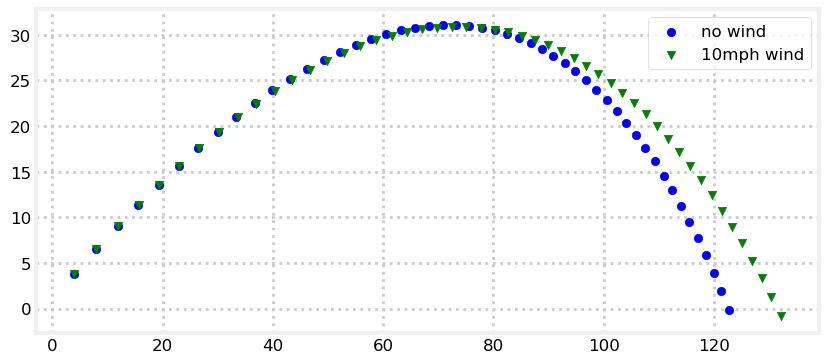

In [66]:
from math import sqrt, exp

def mph_to_mps(x):
    return x * .447

def drag_force(velocity):
    """ Returns the force on a baseball due to air drag at
    the specified velocity. Units are SI"""

    return velocity * (0.0039 + 0.0058 / 
            (1. + exp((velocity-35.)/5.)))

v = mph_to_mps(110.)
x, y = 0., 1.
dt = .1
theta = radians(35)

def solve(x, y, vel, v_wind, launch_angle):
    xs = []
    ys = []
    v_x = vel*cos(launch_angle)
    v_y = vel*sin(launch_angle)
    while y >= 0:
        # Euler equations for x and y
        x += v_x*dt
        y += v_y*dt

        # force due to air drag    
        velocity = sqrt((v_x-v_wind)**2 + v_y**2)    
        F = drag_force(velocity)

        # euler's equations for vx and vy
        v_x = v_x - F*(v_x-v_wind)*dt
        v_y = v_y - 9.8*dt - F*v_y*dt
        
        xs.append(x)
        ys.append(y)
    
    return xs, ys
        
x, y = solve(x=0, y=1, vel=v, v_wind=0, launch_angle=theta)
p1 = plt.scatter(x, y, color='blue', label='no wind')

wind = mph_to_mps(10)
x, y = solve(x=0, y=1, vel=v, v_wind=wind, launch_angle=theta)
p2 = plt.scatter(x, y, color='green', marker="v", 
                 label='10mph wind')
plt.legend(scatterpoints=1);

We can easily see the difference between the trajectory in a vacuum and in the air. I used the same initial velocity and launch angle in the ball in a vacuum section above. We computed that the ball in a vacuum would travel over 240 meters (nearly 800 ft). In the air, the distance is just over 120 meters, or roughly 400 ft. 400ft is a realistic distance for a well hit home run ball, so we can be confident that our simulation is reasonably accurate.

Without further ado we will create a ball simulation that uses the math above to create a more realistic ball trajectory. I will note that the nonlinear behavior of drag means that there is no analytic solution to the ball position at any point in time, so we need to compute the position step-wise. I use Euler's method to propagate the solution; use of a more accurate technique such as Runge-Kutta is left as an exercise for the reader. That modest complication is unnecessary for what we are doing because the accuracy difference between the techniques will be small for the time steps we will be using. 

In [67]:
class BaseballPath(object):
    def __init__(self, x0, y0, launch_angle_deg, velocity_ms, 
                 noise=(1.0, 1.0)): 
        """ Create 2D baseball path object  
           (x = distance from start point in ground plane, 
            y=height above ground)
        
        x0,y0            initial position
        launch_angle_deg angle ball is travelling respective to 
                         ground plane
        velocity_ms      speeed of ball in meters/second
        noise            amount of noise to add to each position
                         in (x, y)
        """
        
        omega = radians(launch_angle_deg)
        self.v_x = velocity_ms * cos(omega)
        self.v_y = velocity_ms * sin(omega)

        self.x = x0
        self.y = y0
        self.noise = noise


    def drag_force(self, velocity):
        """ Returns the force on a baseball due to air drag at
        the specified velocity. Units are SI
        """
        B_m = 0.0039 + 0.0058 / (1. + exp((velocity-35.)/5.))
        return B_m * velocity


    def update(self, dt, vel_wind=0.):
        """ compute the ball position based on the specified time 
        step and wind velocity. Returns (x, y) position tuple.
        """

        # Euler equations for x and y
        self.x += self.v_x*dt
        self.y += self.v_y*dt

        # force due to air drag
        v_x_wind = self.v_x - vel_wind
        v = sqrt(v_x_wind**2 + self.v_y**2)
        F = self.drag_force(v)

        # Euler's equations for velocity
        self.v_x = self.v_x - F*v_x_wind*dt
        self.v_y = self.v_y - 9.81*dt - F*self.v_y*dt

        return (self.x + randn()*self.noise[0], 
                self.y + randn()*self.noise[1])

Now we can test the Kalman filter against measurements created by this model.

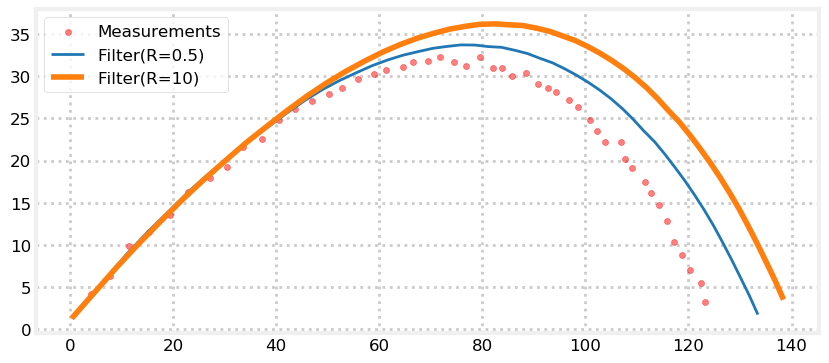

In [68]:
x, y = 0, 1.

theta = 35. # launch angle
v0 = 50.
dt = 1/10.   # time step
g = 9.8

plt.figure()
ball = BaseballPath(x0=x, y0=y, launch_angle_deg=theta,
                    velocity_ms=v0, noise=[.3,.3])
f1 = ball_kf(x, y, theta, v0, dt, r=1.)
f2 = ball_kf(x, y, theta, v0, dt, r=10.)
t = 0
xs, ys = [], []
xs2, ys2 = [], []

while f1.x[2] > 0:
    t += dt
    x, y = ball.update(dt)
    z = np.array([[x, y]]).T

    f1.update(z)
    f2.update(z)
    xs.append(f1.x[0])
    ys.append(f1.x[2])
    xs2.append(f2.x[0])
    ys2.append(f2.x[2])    
    f1.predict(u=-g) 
    f2.predict(u=-g)
    
    p1 = plt.scatter(x, y, color='r', marker='.', s=75, alpha=0.5)

p2, = plt.plot(xs, ys, lw=2)
p3, = plt.plot(xs2, ys2, lw=4)
plt.legend([p1, p2, p3], 
           ['Measurements', 'Filter(R=0.5)', 'Filter(R=10)'],
           loc='best', scatterpoints=1);

I have plotted the output of two different Kalman filter settings. The measurements are depicted as green circles, a Kalman filter with R=0.5 as a thin green line, and a Kalman filter with R=10 as a thick blue line. These R values are chosen merely to show the effect of measurement noise on the output, they are not intended to imply a correct design.

We can see that neither filter does very well. At first both track the measurements well, but as time continues they both diverge. This happens because the state model for air drag is nonlinear and the Kalman filter assumes that it is linear. If you recall our discussion about nonlinearity in the g-h filter chapter we showed why a g-h filter will always lag behind the acceleration of the system. We see the same thing here - the acceleration is negative, so the Kalman filter consistently overshoots the ball position. There is no way for the filter to catch up so long as the acceleration continues, so the filter will continue to diverge.

What can we do to improve this? The best approach is to perform the filtering with a nonlinear Kalman filter, and we will do this in subsequent chapters. However, there is also what I will call an 'engineering' solution to this problem as well. Our Kalman filter assumes that the ball is in a vacuum, and thus that there is no process noise. However, since the ball is in air the atmosphere imparts a force on the ball. We can think of this force as process noise. This is not a particularly rigorous thought; for one thing, this force is anything but Gaussian. Secondly, we can compute this force, so throwing our hands up and saying 'it's random' will not lead to an optimal solution. But let's see what happens if we follow this line of thought.

The following code implements the same Kalman filter as before, but with a non-zero process noise. I plot two examples, one with `Q=.1`, and one with `Q=0.01`.

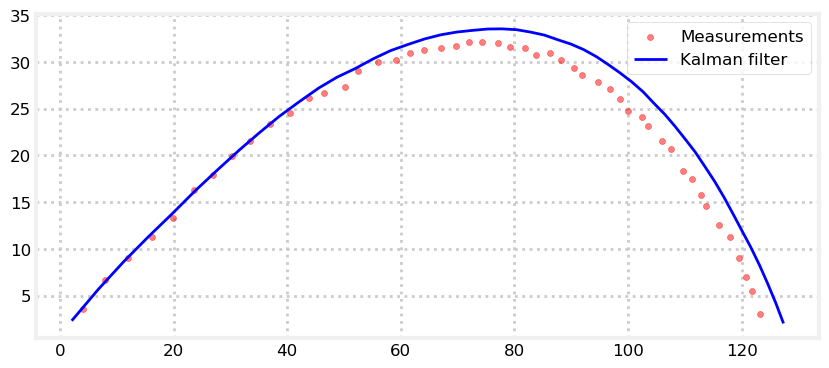

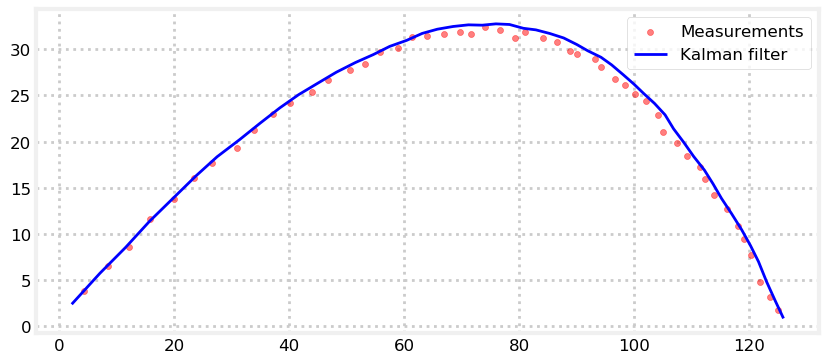

In [69]:
def plot_ball_with_q(q, r=1., noise=0.3):
    x, y = 0., 1.
    theta = 35. # launch angle
    v0 = 50.
    dt = 1/10.   # time step
    g = 9.8

    ball = BaseballPath(x0=x, 
                        y0=y, 
                        launch_angle_deg=theta, 
                        velocity_ms=v0, 
                        noise=[noise,noise])
    f1 = ball_kf(x, y, theta, v0, dt, r=r, q=q)
    t = 0
    xs, ys = [], []

    while f1.x[2] > 0:
        t += dt
        x, y = ball.update(dt)
        z = np.array([[x, y]]).T

        f1.update(z)
        xs.append(f1.x[0])
        ys.append(f1.x[2]) 
        f1.predict(u=-g) 

        p1 = plt.scatter(x, y, c='r', marker='.', s=75, alpha=0.5)

    p2, = plt.plot(xs, ys, lw=2, color='b')
    plt.legend([p1, p2], ['Measurements', 'Kalman filter'])
    plt.show()

plot_ball_with_q(0.01)
plot_ball_with_q(0.1)

The second filter tracks the measurements fairly well. There appears to be a bit of lag, but very little.

Is this a good technique? Usually not, but it depends. Here the nonlinearity of the force on the ball is fairly constant and regular. Assume we are trying to track an automobile - the accelerations will vary as the car changes speeds and turns. When we make the process noise higher than the actual noise in the system the filter will opt to weigh the measurements higher. If you don't have a lot of noise in your measurements this might work for you. However, consider this next plot where I have increased the noise in the measurements.

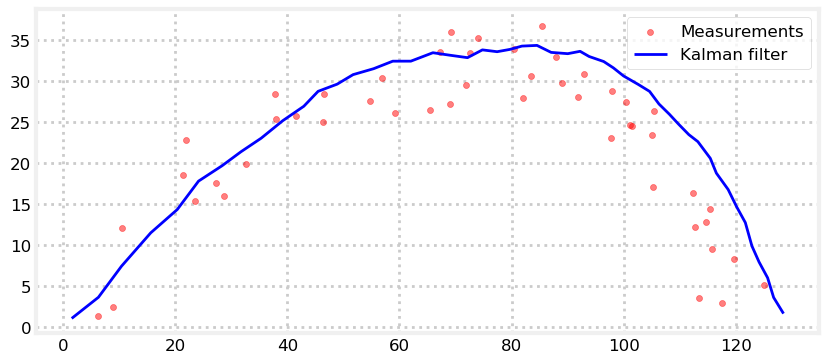

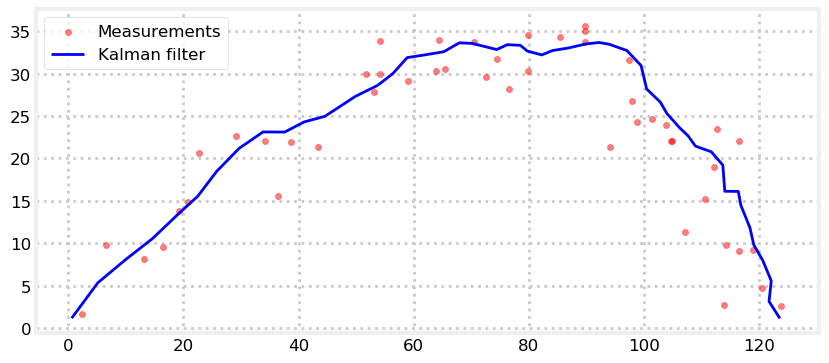

In [70]:
plot_ball_with_q(0.01, r=3, noise=3.)
plot_ball_with_q(0.1, r=3, noise=3.)

This output is terrible. The filter has no choice but to give more weight to the measurements than the process (prediction step), but when the measurements are noisy the filter output will just track the noise. This inherent limitation of the linear Kalman filter is what lead to the development of nonlinear versions of the filter.

With that said, it is certainly possible to use the process noise to deal with small nonlinearities in your system. This is part of the 'black art' of Kalman filters. Our model of the sensors and of the system are never perfect. Sensors are non-Gaussian and our process model is never perfect. You can mask some of this by setting the measurement errors and process errors higher than their theoretically correct values, but the trade off is a non-optimal solution. Certainly it is better to be non-optimal than to have your Kalman filter diverge. However, as we can see in the graphs above, it is easy for the output of the filter to be very bad. It is also very common to run many simulations and tests and to end up with a filter that performs very well under those conditions. Then, when you use the filter on real data the conditions are slightly different and the filter ends up performing terribly. 

For now we will set this problem aside, as we are clearly misapplying the Kalman filter in this example. We will revisit this problem in subsequent chapters to see the effect of using various nonlinear techniques. In some domains you will be able to get away with using a linear Kalman filter for a nonlinear problem, but usually you will have to use one or more of the techniques you will learn in the rest of this book.

## References

[1] Bar-Shalom, Yaakov, et al. *Estimation with Applications to Tracking and Navigation.* John Wiley & Sons, 2001.